In [1]:
import sys
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development import (
    Sequential,
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Linear,
    ReLU,
    ReLU6,
    MaxPool2d,
    Flatten, 

    EarlyStopper,
    dequantize_per_tensor_sy,
    Estimator,
    
    QuantizationGranularity,
    QuantizationScaleType,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
import copy
import random

from tqdm.auto import tqdm

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lenet5_file = f"lenet5_state_dict.pth"
log_compression_details_file = "lenet5_compression_log.csv"

hp_deployment_base_dir = "./HP HP Pavilion Laptop 15-cs3xxx/"
hp_src_dir = os.path.join(hp_deployment_base_dir, "src")
hp_include_dir = os.path.join(hp_deployment_base_dir, "include")

arduino_deployment_base_dir = "./Arduino Nano 33 BLE/"
arduino_src_dir = os.path.join(arduino_deployment_base_dir, "src")
arduino_include_dir = os.path.join(arduino_deployment_base_dir, "include")

LUCKY_NUMBER = 25
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

DEVICE

'cuda'

In [4]:
input_shape = (1, 28, 28)

data_transform = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST("../../../Datasets/", train=True, download=True, transform=data_transform)
mnist_test_dataset = datasets.MNIST("../../../Datasets/", train=False, download=True, transform=data_transform)

mnist_train_loader = data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)
mnist_test_loader = data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [5]:
lenet5_model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, pad=tuple([2]*4), bias=False),
    BatchNorm2d(num_features=6),
    ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
    BatchNorm2d(num_features=16),
    ReLU(),
    # ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),
    # AvgPool2d(kernel_size=2, stride=2, padding=0),

    Flatten(),
    
    Linear(in_features=16*5*5, out_features=84, bias=False),
    ReLU(),
    Linear(in_features=84, out_features=10, bias=True)
).to(DEVICE)

accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()*100

In [6]:
# lenet5_model = Sequential(
#     Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     # BatchNorm2d(num_features=3),
#     ReLU(),
#     Conv2d(in_channels=6, out_channels=3, kernel_size=1, stride=1, pad=[0]*4, bias=False),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=84, bias=False),
#     ReLU(),
#     Linear(in_features=84, out_features=10, bias=True)
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [7]:
# lenet5_model = Sequential(
    
#     Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     ReLU(),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     # BatchNorm2d(num_features=3),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=10, bias=True),
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [8]:
try:
    # raise RuntimeError
    lenet5_model.cpu()
    lenet5_model.load_state_dict(torch.load(lenet5_file, weights_only=True), strict=False)
    lenet5_model.to(DEVICE)

except (RuntimeError, FileNotFoundError) as e:
    early_stopper = EarlyStopper(
        metric_name="validation_loss",
        min_valid_diff=1e-7,
        mode="min",
        patience=4,
        restore_best_state_dict=True,
    )

    criterion_fun = nn.CrossEntropyLoss()
    optimizion_fun = optim.Adam(lenet5_model.parameters(), lr=1.e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

    lenet5_model.fit(
        mnist_train_loader, 25, 
        criterion_fun, optimizion_fun, lr_scheduler,
        validation_dataloader=mnist_test_loader, 
        metrics={"acc" : accuracy_fun},
        callbacks=[early_stopper],
        device=DEVICE
    )
    lenet5_model.cpu()
    torch.save(lenet5_model.state_dict(), lenet5_file)
    lenet5_model.to(DEVICE)
    

In [9]:
param = []

In [10]:
# param += lenet5_model.get_nas_prune_channel(input_shape=input_shape, data_loader=mnist_test_loader, metric_fun=accuracy_fun, device=DEVICE, num_data=500)


In [11]:
import pickle
# with open("param", "wb") as file:
#     pickle.dump(param, file) 
with open("param", "rb") as file:
    param = pickle.load(file)

In [12]:

estimator = Estimator(param, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=500)

# best_metric = float("-inf")
# best_comb = None

# result = []
# for prune_comb in get_all_combinations(prune_channel_hp):
#     metric = estimator.predict(torch.Tensor(prune_comb))
    
#     result.append((prune_comb, metric))

#     print(result)
#     if metric > best_metric:
#         best_metric = metric
#         best_comb = prune_comb

#         return estimator

torch.Size([400, 3]) 400 400 torch.Size([400, 1])
torch.Size([100, 3]) 100 100 torch.Size([100, 1])


  0%|          | 1/500 [00:00<02:27,  3.38it/s]

epoch    0 | train loss 67.8591 | validation loss 56.2288 | train mse 67.8591 | validation mse 56.2288 | train rmse 1.4722 | validation rmse 1.4284 | train abs 1.1629 | validation abs 1.1298


100%|██████████| 4/4 [00:00<00:00, 407.24it/s]


epoch    1 | train loss 61.9954 | validation loss 50.5993 | train mse 61.9954 | validation mse 50.5993 | train rmse 1.3964 | validation rmse 1.3445 | train abs 1.0873 | validation abs 1.0256


  1%|          | 3/500 [00:00<01:07,  7.35it/s]

epoch    2 | train loss 52.7778 | validation loss 36.6642 | train mse 52.7778 | validation mse 36.6642 | train rmse 1.2944 | validation rmse 1.1239 | train abs 0.9492 | validation abs 0.7682


100%|██████████| 4/4 [00:00<00:00, 420.18it/s]


epoch    3 | train loss 36.0671 | validation loss 23.1241 | train mse 36.0671 | validation mse 23.1242 | train rmse 1.0670 | validation rmse 0.9570 | train abs 0.7509 | validation abs 0.7026


  1%|          | 5/500 [00:00<00:55,  8.96it/s]

epoch    4 | train loss 25.9354 | validation loss 21.5168 | train mse 25.9354 | validation mse 21.5168 | train rmse 0.9015 | validation rmse 0.9117 | train abs 0.6959 | validation abs 0.7582


100%|██████████| 4/4 [00:00<00:00, 851.12it/s]


epoch    5 | train loss 21.5945 | validation loss 18.1867 | train mse 21.5945 | validation mse 18.1867 | train rmse 0.8316 | validation rmse 0.8285 | train abs 0.6367 | validation abs 0.6515


  1%|▏         | 7/500 [00:00<00:45, 10.93it/s]

epoch    6 | train loss 17.3511 | validation loss 16.5790 | train mse 17.3511 | validation mse 16.5790 | train rmse 0.7459 | validation rmse 0.7786 | train abs 0.5544 | validation abs 0.6072


100%|██████████| 4/4 [00:00<00:00, 568.06it/s]


epoch    7 | train loss 17.4563 | validation loss 14.9233 | train mse 17.4563 | validation mse 14.9233 | train rmse 0.7493 | validation rmse 0.7437 | train abs 0.5404 | validation abs 0.5765


  2%|▏         | 9/500 [00:00<00:40, 12.14it/s]

epoch    8 | train loss 13.1471 | validation loss 14.2644 | train mse 13.1471 | validation mse 14.2644 | train rmse 0.6442 | validation rmse 0.7304 | train abs 0.4667 | validation abs 0.5681


100%|██████████| 4/4 [00:00<00:00, 407.99it/s]


epoch    9 | train loss 15.0900 | validation loss 13.9249 | train mse 15.0900 | validation mse 13.9249 | train rmse 0.6945 | validation rmse 0.7121 | train abs 0.5213 | validation abs 0.5618


  2%|▏         | 11/500 [00:01<00:37, 12.98it/s]

epoch   10 | train loss 14.7145 | validation loss 13.4936 | train mse 14.7145 | validation mse 13.4936 | train rmse 0.6832 | validation rmse 0.7005 | train abs 0.4965 | validation abs 0.5542


100%|██████████| 4/4 [00:00<00:00, 631.32it/s]


epoch   11 | train loss 14.1019 | validation loss 13.1881 | train mse 14.1019 | validation mse 13.1881 | train rmse 0.6718 | validation rmse 0.7023 | train abs 0.4750 | validation abs 0.5512


  3%|▎         | 13/500 [00:01<00:35, 13.79it/s]

epoch   12 | train loss 15.9007 | validation loss 13.0818 | train mse 15.9007 | validation mse 13.0818 | train rmse 0.7155 | validation rmse 0.6976 | train abs 0.5171 | validation abs 0.5462


100%|██████████| 4/4 [00:00<00:00, 587.50it/s]


epoch   13 | train loss 14.1043 | validation loss 12.9627 | train mse 14.1043 | validation mse 12.9627 | train rmse 0.6711 | validation rmse 0.6810 | train abs 0.4844 | validation abs 0.5355


  3%|▎         | 15/500 [00:01<00:35, 13.75it/s]

epoch   14 | train loss 13.4555 | validation loss 12.7025 | train mse 13.4555 | validation mse 12.7025 | train rmse 0.6554 | validation rmse 0.6737 | train abs 0.4660 | validation abs 0.5294


100%|██████████| 4/4 [00:00<00:00, 341.93it/s]


epoch   15 | train loss 16.4564 | validation loss 12.3573 | train mse 16.4564 | validation mse 12.3573 | train rmse 0.7122 | validation rmse 0.6769 | train abs 0.4929 | validation abs 0.5273


  3%|▎         | 17/500 [00:01<00:35, 13.48it/s]

epoch   16 | train loss 13.7546 | validation loss 12.2657 | train mse 13.7546 | validation mse 12.2657 | train rmse 0.6593 | validation rmse 0.6773 | train abs 0.4638 | validation abs 0.5235


100%|██████████| 4/4 [00:00<00:00, 396.32it/s]


epoch   17 | train loss 12.4946 | validation loss 12.3740 | train mse 12.4946 | validation mse 12.3740 | train rmse 0.6290 | validation rmse 0.6657 | train abs 0.4544 | validation abs 0.5159


  4%|▍         | 19/500 [00:01<00:37, 12.72it/s]

epoch   18 | train loss 13.5771 | validation loss 12.1972 | train mse 13.5771 | validation mse 12.1972 | train rmse 0.6510 | validation rmse 0.6644 | train abs 0.4648 | validation abs 0.5122


100%|██████████| 4/4 [00:00<00:00, 462.86it/s]


epoch   19 | train loss 14.1783 | validation loss 11.9403 | train mse 14.1783 | validation mse 11.9403 | train rmse 0.6712 | validation rmse 0.6732 | train abs 0.4767 | validation abs 0.5126


  4%|▍         | 21/500 [00:01<00:38, 12.41it/s]

epoch   20 | train loss 14.7392 | validation loss 11.5289 | train mse 14.7392 | validation mse 11.5289 | train rmse 0.6815 | validation rmse 0.6562 | train abs 0.4865 | validation abs 0.5032


100%|██████████| 4/4 [00:00<00:00, 603.17it/s]


epoch   21 | train loss 13.9208 | validation loss 11.4922 | train mse 13.9208 | validation mse 11.4922 | train rmse 0.6670 | validation rmse 0.6629 | train abs 0.4768 | validation abs 0.5039


  5%|▍         | 23/500 [00:01<00:39, 12.12it/s]

epoch   22 | train loss 15.2815 | validation loss 11.2590 | train mse 15.2815 | validation mse 11.2590 | train rmse 0.6974 | validation rmse 0.6438 | train abs 0.4961 | validation abs 0.4932


100%|██████████| 4/4 [00:00<00:00, 496.85it/s]


epoch   23 | train loss 13.2185 | validation loss 11.4469 | train mse 13.2185 | validation mse 11.4469 | train rmse 0.6408 | validation rmse 0.6587 | train abs 0.4439 | validation abs 0.4979


  5%|▌         | 25/500 [00:02<00:40, 11.74it/s]

epoch   24 | train loss 13.3995 | validation loss 11.3100 | train mse 13.3995 | validation mse 11.3100 | train rmse 0.6455 | validation rmse 0.6413 | train abs 0.4655 | validation abs 0.4881


100%|██████████| 4/4 [00:00<00:00, 470.19it/s]


epoch   25 | train loss 12.9037 | validation loss 11.0493 | train mse 12.9037 | validation mse 11.0493 | train rmse 0.6304 | validation rmse 0.6388 | train abs 0.4519 | validation abs 0.4840


  5%|▌         | 27/500 [00:02<00:40, 11.71it/s]

epoch   26 | train loss 13.0186 | validation loss 10.8464 | train mse 13.0186 | validation mse 10.8464 | train rmse 0.6365 | validation rmse 0.6223 | train abs 0.4480 | validation abs 0.4735


100%|██████████| 4/4 [00:00<00:00, 483.73it/s]


epoch   27 | train loss 12.9807 | validation loss 10.8327 | train mse 12.9807 | validation mse 10.8327 | train rmse 0.6375 | validation rmse 0.6389 | train abs 0.4515 | validation abs 0.4800


  6%|▌         | 29/500 [00:02<00:40, 11.51it/s]

epoch   28 | train loss 13.3487 | validation loss 10.6131 | train mse 13.3487 | validation mse 10.6131 | train rmse 0.6475 | validation rmse 0.6256 | train abs 0.4560 | validation abs 0.4707


100%|██████████| 4/4 [00:00<00:00, 579.16it/s]


epoch   29 | train loss 13.7538 | validation loss 10.4572 | train mse 13.7538 | validation mse 10.4572 | train rmse 0.6583 | validation rmse 0.6106 | train abs 0.4573 | validation abs 0.4605


  6%|▌         | 31/500 [00:02<00:40, 11.51it/s]

epoch   30 | train loss 12.7405 | validation loss 10.5212 | train mse 12.7405 | validation mse 10.5212 | train rmse 0.6239 | validation rmse 0.6357 | train abs 0.4417 | validation abs 0.4711


100%|██████████| 4/4 [00:00<00:00, 496.57it/s]


epoch   31 | train loss 13.2896 | validation loss 10.3278 | train mse 13.2896 | validation mse 10.3278 | train rmse 0.6450 | validation rmse 0.6258 | train abs 0.4530 | validation abs 0.4637


  7%|▋         | 33/500 [00:02<00:41, 11.36it/s]

epoch   32 | train loss 14.6564 | validation loss 10.1219 | train mse 14.6564 | validation mse 10.1219 | train rmse 0.6736 | validation rmse 0.6139 | train abs 0.4639 | validation abs 0.4545


100%|██████████| 4/4 [00:00<00:00, 482.67it/s]


epoch   33 | train loss 11.7029 | validation loss 9.7880 | train mse 11.7029 | validation mse 9.7880 | train rmse 0.6114 | validation rmse 0.6089 | train abs 0.4289 | validation abs 0.4500


  7%|▋         | 35/500 [00:03<00:40, 11.40it/s]

epoch   34 | train loss 13.1842 | validation loss 9.4265 | train mse 13.1842 | validation mse 9.4265 | train rmse 0.6383 | validation rmse 0.5960 | train abs 0.4540 | validation abs 0.4417


100%|██████████| 4/4 [00:00<00:00, 230.73it/s]


epoch   35 | train loss 13.8249 | validation loss 9.4989 | train mse 13.8249 | validation mse 9.4989 | train rmse 0.6676 | validation rmse 0.5972 | train abs 0.4740 | validation abs 0.4421


  7%|▋         | 37/500 [00:03<00:42, 10.97it/s]

epoch   36 | train loss 12.3609 | validation loss 9.5122 | train mse 12.3609 | validation mse 9.5122 | train rmse 0.6262 | validation rmse 0.5930 | train abs 0.4503 | validation abs 0.4385


100%|██████████| 4/4 [00:00<00:00, 447.86it/s]


epoch   37 | train loss 11.7492 | validation loss 9.4205 | train mse 11.7492 | validation mse 9.4205 | train rmse 0.6147 | validation rmse 0.5923 | train abs 0.4352 | validation abs 0.4376


  8%|▊         | 39/500 [00:03<00:39, 11.67it/s]

epoch   38 | train loss 11.0262 | validation loss 9.3254 | train mse 11.0262 | validation mse 9.3254 | train rmse 0.5826 | validation rmse 0.5889 | train abs 0.4138 | validation abs 0.4352


100%|██████████| 4/4 [00:00<00:00, 454.85it/s]


epoch   39 | train loss 13.8383 | validation loss 9.6877 | train mse 13.8383 | validation mse 9.6877 | train rmse 0.6537 | validation rmse 0.6166 | train abs 0.4652 | validation abs 0.4500


  8%|▊         | 41/500 [00:03<00:38, 11.93it/s]

epoch   40 | train loss 12.2527 | validation loss 9.1719 | train mse 12.2527 | validation mse 9.1719 | train rmse 0.6211 | validation rmse 0.5933 | train abs 0.4399 | validation abs 0.4346


100%|██████████| 4/4 [00:00<00:00, 562.35it/s]


epoch   41 | train loss 11.4892 | validation loss 9.0001 | train mse 11.4892 | validation mse 9.0001 | train rmse 0.6039 | validation rmse 0.5683 | train abs 0.4261 | validation abs 0.4188


  9%|▊         | 43/500 [00:03<00:36, 12.59it/s]

epoch   42 | train loss 14.8806 | validation loss 9.3906 | train mse 14.8806 | validation mse 9.3906 | train rmse 0.6750 | validation rmse 0.5982 | train abs 0.4664 | validation abs 0.4379


100%|██████████| 4/4 [00:00<00:00, 409.35it/s]


epoch   43 | train loss 12.1030 | validation loss 9.3547 | train mse 12.1030 | validation mse 9.3547 | train rmse 0.6192 | validation rmse 0.5989 | train abs 0.4335 | validation abs 0.4391


  9%|▉         | 45/500 [00:03<00:38, 11.80it/s]

epoch   44 | train loss 12.1446 | validation loss 9.2722 | train mse 12.1446 | validation mse 9.2722 | train rmse 0.6173 | validation rmse 0.5962 | train abs 0.4283 | validation abs 0.4359


100%|██████████| 4/4 [00:00<00:00, 537.65it/s]


epoch   45 | train loss 10.4963 | validation loss 9.1226 | train mse 10.4963 | validation mse 9.1226 | train rmse 0.5736 | validation rmse 0.5906 | train abs 0.4119 | validation abs 0.4308


  9%|▉         | 47/500 [00:04<00:38, 11.66it/s]

epoch   46 | train loss 12.4783 | validation loss 9.1332 | train mse 12.4783 | validation mse 9.1332 | train rmse 0.6270 | validation rmse 0.5925 | train abs 0.4416 | validation abs 0.4317


100%|██████████| 4/4 [00:00<00:00, 356.54it/s]


epoch   47 | train loss 12.5537 | validation loss 8.8842 | train mse 12.5537 | validation mse 8.8842 | train rmse 0.6313 | validation rmse 0.5854 | train abs 0.4508 | validation abs 0.4264


 10%|▉         | 49/500 [00:04<00:38, 11.64it/s]

epoch   48 | train loss 10.9715 | validation loss 8.5436 | train mse 10.9715 | validation mse 8.5436 | train rmse 0.5879 | validation rmse 0.5693 | train abs 0.4196 | validation abs 0.4149


100%|██████████| 4/4 [00:00<00:00, 441.58it/s]


epoch   49 | train loss 11.6374 | validation loss 8.4748 | train mse 11.6374 | validation mse 8.4748 | train rmse 0.6068 | validation rmse 0.5520 | train abs 0.4212 | validation abs 0.4030


 10%|█         | 51/500 [00:04<00:35, 12.48it/s]

epoch   50 | train loss 13.0729 | validation loss 8.4653 | train mse 13.0729 | validation mse 8.4653 | train rmse 0.6362 | validation rmse 0.5448 | train abs 0.4384 | validation abs 0.3990


100%|██████████| 4/4 [00:00<00:00, 840.75it/s]


epoch   51 | train loss 11.1862 | validation loss 8.3748 | train mse 11.1862 | validation mse 8.3748 | train rmse 0.5891 | validation rmse 0.5655 | train abs 0.4157 | validation abs 0.4133


 11%|█         | 53/500 [00:04<00:33, 13.50it/s]

epoch   52 | train loss 12.2669 | validation loss 8.1445 | train mse 12.2669 | validation mse 8.1445 | train rmse 0.6276 | validation rmse 0.5501 | train abs 0.4434 | validation abs 0.4042


100%|██████████| 4/4 [00:00<00:00, 995.80it/s]


epoch   53 | train loss 11.6611 | validation loss 8.2059 | train mse 11.6611 | validation mse 8.2059 | train rmse 0.6073 | validation rmse 0.5495 | train abs 0.4275 | validation abs 0.4043


 11%|█         | 55/500 [00:04<00:30, 14.72it/s]

epoch   54 | train loss 11.0442 | validation loss 8.3090 | train mse 11.0442 | validation mse 8.3090 | train rmse 0.5945 | validation rmse 0.5525 | train abs 0.4289 | validation abs 0.4063


100%|██████████| 4/4 [00:00<00:00, 858.13it/s]


epoch   55 | train loss 11.9320 | validation loss 8.1781 | train mse 11.9320 | validation mse 8.1781 | train rmse 0.6135 | validation rmse 0.5520 | train abs 0.4346 | validation abs 0.4068


 11%|█▏        | 57/500 [00:04<00:28, 15.70it/s]

epoch   56 | train loss 11.6576 | validation loss 8.2896 | train mse 11.6576 | validation mse 8.2896 | train rmse 0.6108 | validation rmse 0.5577 | train abs 0.4255 | validation abs 0.4119


100%|██████████| 4/4 [00:00<00:00, 751.67it/s]


epoch   57 | train loss 10.0450 | validation loss 8.1589 | train mse 10.0450 | validation mse 8.1589 | train rmse 0.5636 | validation rmse 0.5497 | train abs 0.3882 | validation abs 0.4058


100%|██████████| 4/4 [00:00<00:00, 987.01it/s]


epoch   58 | train loss 10.3643 | validation loss 7.9806 | train mse 10.3643 | validation mse 7.9806 | train rmse 0.5703 | validation rmse 0.5446 | train abs 0.4162 | validation abs 0.4006


 12%|█▏        | 60/500 [00:04<00:25, 17.28it/s]

epoch   59 | train loss 11.3106 | validation loss 7.8566 | train mse 11.3106 | validation mse 7.8566 | train rmse 0.5825 | validation rmse 0.5507 | train abs 0.3977 | validation abs 0.4036


100%|██████████| 4/4 [00:00<00:00, 972.59it/s]


epoch   60 | train loss 10.9714 | validation loss 8.0914 | train mse 10.9714 | validation mse 8.0914 | train rmse 0.5875 | validation rmse 0.5640 | train abs 0.4027 | validation abs 0.4104


 12%|█▏        | 62/500 [00:04<00:24, 17.66it/s]

epoch   61 | train loss 11.5633 | validation loss 7.4606 | train mse 11.5633 | validation mse 7.4606 | train rmse 0.5974 | validation rmse 0.5361 | train abs 0.4284 | validation abs 0.3918


100%|██████████| 4/4 [00:00<00:00, 566.95it/s]


epoch   62 | train loss 12.4829 | validation loss 7.3592 | train mse 12.4829 | validation mse 7.3592 | train rmse 0.6275 | validation rmse 0.5316 | train abs 0.4331 | validation abs 0.3865


 13%|█▎        | 64/500 [00:05<00:26, 16.15it/s]

epoch   63 | train loss 10.1715 | validation loss 7.5014 | train mse 10.1715 | validation mse 7.5014 | train rmse 0.5707 | validation rmse 0.5378 | train abs 0.4032 | validation abs 0.3903


100%|██████████| 4/4 [00:00<00:00, 472.81it/s]


epoch   64 | train loss 11.2551 | validation loss 7.4822 | train mse 11.2551 | validation mse 7.4822 | train rmse 0.5907 | validation rmse 0.5344 | train abs 0.4161 | validation abs 0.3895


 13%|█▎        | 66/500 [00:05<00:29, 14.48it/s]

epoch   65 | train loss 11.6176 | validation loss 8.1276 | train mse 11.6176 | validation mse 8.1276 | train rmse 0.6018 | validation rmse 0.5651 | train abs 0.4284 | validation abs 0.4133


100%|██████████| 4/4 [00:00<00:00, 418.70it/s]


epoch   66 | train loss 9.7246 | validation loss 7.8754 | train mse 9.7246 | validation mse 7.8754 | train rmse 0.5520 | validation rmse 0.5535 | train abs 0.3967 | validation abs 0.4082


 14%|█▎        | 68/500 [00:05<00:33, 13.02it/s]

epoch   67 | train loss 12.6234 | validation loss 7.7280 | train mse 12.6234 | validation mse 7.7280 | train rmse 0.6292 | validation rmse 0.5469 | train abs 0.4503 | validation abs 0.4010


100%|██████████| 4/4 [00:00<00:00, 510.66it/s]


epoch   68 | train loss 8.4916 | validation loss 7.1347 | train mse 8.4916 | validation mse 7.1347 | train rmse 0.5145 | validation rmse 0.5125 | train abs 0.3645 | validation abs 0.3726


 14%|█▍        | 70/500 [00:05<00:33, 12.72it/s]

epoch   69 | train loss 12.0066 | validation loss 7.0860 | train mse 12.0066 | validation mse 7.0860 | train rmse 0.6091 | validation rmse 0.5156 | train abs 0.4108 | validation abs 0.3744


100%|██████████| 4/4 [00:00<00:00, 430.99it/s]


epoch   70 | train loss 9.3742 | validation loss 7.6292 | train mse 9.3742 | validation mse 7.6292 | train rmse 0.5456 | validation rmse 0.5457 | train abs 0.3867 | validation abs 0.3972


 14%|█▍        | 72/500 [00:05<00:35, 12.21it/s]

epoch   71 | train loss 9.5997 | validation loss 7.2282 | train mse 9.5997 | validation mse 7.2282 | train rmse 0.5535 | validation rmse 0.5259 | train abs 0.3866 | validation abs 0.3826


100%|██████████| 4/4 [00:00<00:00, 572.64it/s]


epoch   72 | train loss 9.4033 | validation loss 6.7267 | train mse 9.4033 | validation mse 6.7267 | train rmse 0.5427 | validation rmse 0.4990 | train abs 0.3885 | validation abs 0.3625


 15%|█▍        | 74/500 [00:05<00:36, 11.82it/s]

epoch   73 | train loss 10.5418 | validation loss 6.9331 | train mse 10.5418 | validation mse 6.9331 | train rmse 0.5752 | validation rmse 0.5134 | train abs 0.4103 | validation abs 0.3737


100%|██████████| 4/4 [00:00<00:00, 434.15it/s]


epoch   74 | train loss 8.8672 | validation loss 7.2334 | train mse 8.8672 | validation mse 7.2334 | train rmse 0.5223 | validation rmse 0.5319 | train abs 0.3770 | validation abs 0.3873


 15%|█▌        | 76/500 [00:06<00:36, 11.55it/s]

epoch   75 | train loss 10.4873 | validation loss 6.8170 | train mse 10.4873 | validation mse 6.8170 | train rmse 0.5783 | validation rmse 0.5113 | train abs 0.4123 | validation abs 0.3712


100%|██████████| 4/4 [00:00<00:00, 571.80it/s]


epoch   76 | train loss 11.3764 | validation loss 7.2376 | train mse 11.3764 | validation mse 7.2376 | train rmse 0.6003 | validation rmse 0.5335 | train abs 0.4121 | validation abs 0.3862


 16%|█▌        | 78/500 [00:06<00:38, 10.90it/s]

epoch   77 | train loss 10.4975 | validation loss 7.8196 | train mse 10.4975 | validation mse 7.8196 | train rmse 0.5739 | validation rmse 0.5562 | train abs 0.4006 | validation abs 0.4044


100%|██████████| 4/4 [00:00<00:00, 352.51it/s]


epoch   78 | train loss 11.5137 | validation loss 6.4351 | train mse 11.5137 | validation mse 6.4351 | train rmse 0.6064 | validation rmse 0.4931 | train abs 0.4253 | validation abs 0.3581


 16%|█▌        | 80/500 [00:06<00:40, 10.48it/s]

epoch   79 | train loss 10.5062 | validation loss 6.4145 | train mse 10.5062 | validation mse 6.4145 | train rmse 0.5769 | validation rmse 0.4964 | train abs 0.4027 | validation abs 0.3597


100%|██████████| 4/4 [00:00<00:00, 826.30it/s]


epoch   80 | train loss 10.7732 | validation loss 6.5838 | train mse 10.7732 | validation mse 6.5838 | train rmse 0.5826 | validation rmse 0.5071 | train abs 0.3981 | validation abs 0.3659


 16%|█▋        | 82/500 [00:06<00:35, 11.77it/s]

epoch   81 | train loss 9.6539 | validation loss 6.2497 | train mse 9.6539 | validation mse 6.2497 | train rmse 0.5531 | validation rmse 0.4922 | train abs 0.3842 | validation abs 0.3565


100%|██████████| 4/4 [00:00<00:00, 468.19it/s]


epoch   82 | train loss 12.0146 | validation loss 6.3341 | train mse 12.0146 | validation mse 6.3341 | train rmse 0.6156 | validation rmse 0.4952 | train abs 0.4282 | validation abs 0.3586


 17%|█▋        | 84/500 [00:06<00:34, 12.07it/s]

epoch   83 | train loss 9.8970 | validation loss 6.5805 | train mse 9.8970 | validation mse 6.5805 | train rmse 0.5578 | validation rmse 0.5079 | train abs 0.3922 | validation abs 0.3703


100%|██████████| 4/4 [00:00<00:00, 643.79it/s]


epoch   84 | train loss 10.6544 | validation loss 6.7241 | train mse 10.6544 | validation mse 6.7241 | train rmse 0.5815 | validation rmse 0.5148 | train abs 0.4026 | validation abs 0.3805


 17%|█▋        | 86/500 [00:07<00:32, 12.74it/s]

epoch   85 | train loss 10.3470 | validation loss 6.3101 | train mse 10.3470 | validation mse 6.3101 | train rmse 0.5676 | validation rmse 0.4976 | train abs 0.3969 | validation abs 0.3673


100%|██████████| 4/4 [00:00<00:00, 599.89it/s]


epoch   86 | train loss 9.9100 | validation loss 5.7691 | train mse 9.9100 | validation mse 5.7691 | train rmse 0.5633 | validation rmse 0.4608 | train abs 0.3879 | validation abs 0.3379


 18%|█▊        | 88/500 [00:07<00:31, 12.90it/s]

epoch   87 | train loss 9.3303 | validation loss 5.6739 | train mse 9.3303 | validation mse 5.6739 | train rmse 0.5382 | validation rmse 0.4631 | train abs 0.3674 | validation abs 0.3418


100%|██████████| 4/4 [00:00<00:00, 482.91it/s]


epoch   88 | train loss 10.9520 | validation loss 5.9977 | train mse 10.9520 | validation mse 5.9977 | train rmse 0.5911 | validation rmse 0.4850 | train abs 0.4122 | validation abs 0.3606


 18%|█▊        | 90/500 [00:07<00:32, 12.44it/s]

epoch   89 | train loss 10.2507 | validation loss 6.3136 | train mse 10.2507 | validation mse 6.3136 | train rmse 0.5706 | validation rmse 0.4985 | train abs 0.4082 | validation abs 0.3698


100%|██████████| 4/4 [00:00<00:00, 523.78it/s]


epoch   90 | train loss 8.7074 | validation loss 6.2880 | train mse 8.7074 | validation mse 6.2880 | train rmse 0.5234 | validation rmse 0.4975 | train abs 0.3832 | validation abs 0.3634


 18%|█▊        | 92/500 [00:07<00:34, 11.70it/s]

epoch   91 | train loss 11.0134 | validation loss 6.1078 | train mse 11.0134 | validation mse 6.1078 | train rmse 0.5876 | validation rmse 0.4888 | train abs 0.4141 | validation abs 0.3542


100%|██████████| 4/4 [00:00<00:00, 488.06it/s]


epoch   92 | train loss 10.3459 | validation loss 5.7619 | train mse 10.3459 | validation mse 5.7619 | train rmse 0.5723 | validation rmse 0.4721 | train abs 0.3891 | validation abs 0.3397


 19%|█▉        | 94/500 [00:07<00:34, 11.63it/s]

epoch   93 | train loss 9.8230 | validation loss 5.9901 | train mse 9.8230 | validation mse 5.9901 | train rmse 0.5572 | validation rmse 0.4835 | train abs 0.4090 | validation abs 0.3512


100%|██████████| 4/4 [00:00<00:00, 364.10it/s]


epoch   94 | train loss 10.6289 | validation loss 5.8600 | train mse 10.6289 | validation mse 5.8600 | train rmse 0.5815 | validation rmse 0.4787 | train abs 0.4006 | validation abs 0.3468


 19%|█▉        | 96/500 [00:07<00:36, 11.06it/s]

epoch   95 | train loss 8.8720 | validation loss 5.6528 | train mse 8.8720 | validation mse 5.6528 | train rmse 0.5336 | validation rmse 0.4680 | train abs 0.3747 | validation abs 0.3390


100%|██████████| 4/4 [00:00<00:00, 436.79it/s]


epoch   96 | train loss 9.8957 | validation loss 5.4105 | train mse 9.8957 | validation mse 5.4105 | train rmse 0.5613 | validation rmse 0.4543 | train abs 0.3848 | validation abs 0.3297


 20%|█▉        | 98/500 [00:08<00:36, 11.12it/s]

epoch   97 | train loss 9.6674 | validation loss 5.6716 | train mse 9.6674 | validation mse 5.6716 | train rmse 0.5511 | validation rmse 0.4697 | train abs 0.3845 | validation abs 0.3438


100%|██████████| 4/4 [00:00<00:00, 427.59it/s]


epoch   98 | train loss 9.8569 | validation loss 5.5274 | train mse 9.8569 | validation mse 5.5274 | train rmse 0.5550 | validation rmse 0.4625 | train abs 0.3939 | validation abs 0.3374


 20%|██        | 100/500 [00:08<00:37, 10.76it/s]

epoch   99 | train loss 8.2143 | validation loss 5.6530 | train mse 8.2143 | validation mse 5.6530 | train rmse 0.5088 | validation rmse 0.4694 | train abs 0.3590 | validation abs 0.3427


100%|██████████| 4/4 [00:00<00:00, 632.82it/s]


epoch  100 | train loss 8.2480 | validation loss 5.5779 | train mse 8.2480 | validation mse 5.5779 | train rmse 0.5106 | validation rmse 0.4659 | train abs 0.3611 | validation abs 0.3394


 20%|██        | 102/500 [00:08<00:35, 11.29it/s]

epoch  101 | train loss 10.8412 | validation loss 5.6219 | train mse 10.8412 | validation mse 5.6219 | train rmse 0.5891 | validation rmse 0.4681 | train abs 0.3983 | validation abs 0.3432


100%|██████████| 4/4 [00:00<00:00, 361.46it/s]


epoch  102 | train loss 8.6972 | validation loss 6.4300 | train mse 8.6972 | validation mse 6.4300 | train rmse 0.5265 | validation rmse 0.5035 | train abs 0.3695 | validation abs 0.3668


 21%|██        | 104/500 [00:08<00:34, 11.59it/s]

epoch  103 | train loss 8.9637 | validation loss 5.8924 | train mse 8.9637 | validation mse 5.8924 | train rmse 0.5325 | validation rmse 0.4817 | train abs 0.3783 | validation abs 0.3466


100%|██████████| 4/4 [00:00<00:00, 509.88it/s]


epoch  104 | train loss 7.6761 | validation loss 5.5623 | train mse 7.6761 | validation mse 5.5623 | train rmse 0.4974 | validation rmse 0.4669 | train abs 0.3513 | validation abs 0.3368


 21%|██        | 106/500 [00:08<00:35, 11.25it/s]

epoch  105 | train loss 9.0324 | validation loss 5.0482 | train mse 9.0324 | validation mse 5.0482 | train rmse 0.5356 | validation rmse 0.4420 | train abs 0.3847 | validation abs 0.3179


100%|██████████| 4/4 [00:00<00:00, 505.05it/s]


epoch  106 | train loss 10.3954 | validation loss 5.3071 | train mse 10.3954 | validation mse 5.3071 | train rmse 0.5758 | validation rmse 0.4560 | train abs 0.3947 | validation abs 0.3300


 22%|██▏       | 108/500 [00:08<00:36, 10.80it/s]

epoch  107 | train loss 8.8064 | validation loss 4.9381 | train mse 8.8064 | validation mse 4.9381 | train rmse 0.5290 | validation rmse 0.4369 | train abs 0.3689 | validation abs 0.3103


100%|██████████| 4/4 [00:00<00:00, 476.19it/s]


epoch  108 | train loss 11.2175 | validation loss 4.8641 | train mse 11.2175 | validation mse 4.8641 | train rmse 0.5897 | validation rmse 0.4353 | train abs 0.3917 | validation abs 0.3112


 22%|██▏       | 110/500 [00:09<00:33, 11.81it/s]

epoch  109 | train loss 7.6982 | validation loss 4.6675 | train mse 7.6982 | validation mse 4.6675 | train rmse 0.4949 | validation rmse 0.4261 | train abs 0.3466 | validation abs 0.3042


100%|██████████| 4/4 [00:00<00:00, 507.57it/s]


epoch  110 | train loss 8.8571 | validation loss 4.6808 | train mse 8.8571 | validation mse 4.6808 | train rmse 0.5250 | validation rmse 0.4274 | train abs 0.3622 | validation abs 0.3090


 22%|██▏       | 112/500 [00:09<00:32, 11.79it/s]

epoch  111 | train loss 9.5293 | validation loss 5.6885 | train mse 9.5293 | validation mse 5.6885 | train rmse 0.5381 | validation rmse 0.4713 | train abs 0.3733 | validation abs 0.3474


100%|██████████| 4/4 [00:00<00:00, 450.29it/s]


epoch  112 | train loss 8.3979 | validation loss 4.5992 | train mse 8.3979 | validation mse 4.5992 | train rmse 0.5170 | validation rmse 0.4221 | train abs 0.3651 | validation abs 0.2964


 23%|██▎       | 114/500 [00:09<00:33, 11.46it/s]

epoch  113 | train loss 6.6393 | validation loss 4.5824 | train mse 6.6393 | validation mse 4.5824 | train rmse 0.4608 | validation rmse 0.4219 | train abs 0.3352 | validation abs 0.2977


100%|██████████| 4/4 [00:00<00:00, 551.85it/s]


epoch  114 | train loss 7.6626 | validation loss 4.6064 | train mse 7.6626 | validation mse 4.6064 | train rmse 0.4894 | validation rmse 0.4233 | train abs 0.3443 | validation abs 0.3001


 23%|██▎       | 116/500 [00:09<00:34, 11.24it/s]

epoch  115 | train loss 9.4647 | validation loss 5.1259 | train mse 9.4647 | validation mse 5.1259 | train rmse 0.5499 | validation rmse 0.4479 | train abs 0.3933 | validation abs 0.3259


100%|██████████| 4/4 [00:00<00:00, 578.68it/s]


epoch  116 | train loss 8.4596 | validation loss 5.4353 | train mse 8.4596 | validation mse 5.4353 | train rmse 0.5200 | validation rmse 0.4612 | train abs 0.3742 | validation abs 0.3381


 24%|██▎       | 118/500 [00:09<00:34, 11.18it/s]

epoch  117 | train loss 8.2167 | validation loss 4.9130 | train mse 8.2167 | validation mse 4.9130 | train rmse 0.5125 | validation rmse 0.4385 | train abs 0.3573 | validation abs 0.3131


100%|██████████| 4/4 [00:00<00:00, 446.57it/s]


epoch  118 | train loss 9.3176 | validation loss 4.5809 | train mse 9.3176 | validation mse 4.5809 | train rmse 0.5419 | validation rmse 0.4219 | train abs 0.3777 | validation abs 0.2962


 24%|██▍       | 120/500 [00:10<00:34, 10.92it/s]

epoch  119 | train loss 11.0331 | validation loss 4.6402 | train mse 11.0331 | validation mse 4.6402 | train rmse 0.5768 | validation rmse 0.4255 | train abs 0.3978 | validation abs 0.2995


100%|██████████| 4/4 [00:00<00:00, 424.00it/s]


epoch  120 | train loss 11.1358 | validation loss 5.8573 | train mse 11.1358 | validation mse 5.8573 | train rmse 0.5927 | validation rmse 0.4787 | train abs 0.3997 | validation abs 0.3435


 24%|██▍       | 122/500 [00:10<00:35, 10.69it/s]

epoch  121 | train loss 8.8318 | validation loss 4.3658 | train mse 8.8318 | validation mse 4.3658 | train rmse 0.5321 | validation rmse 0.4063 | train abs 0.3629 | validation abs 0.2874


100%|██████████| 4/4 [00:00<00:00, 502.72it/s]


epoch  122 | train loss 8.2087 | validation loss 4.2110 | train mse 8.2087 | validation mse 4.2110 | train rmse 0.5066 | validation rmse 0.4022 | train abs 0.3587 | validation abs 0.2834


 25%|██▍       | 124/500 [00:10<00:34, 10.78it/s]

epoch  123 | train loss 7.9416 | validation loss 4.7301 | train mse 7.9416 | validation mse 4.7301 | train rmse 0.4953 | validation rmse 0.4302 | train abs 0.3560 | validation abs 0.3103


100%|██████████| 4/4 [00:00<00:00, 532.15it/s]


epoch  124 | train loss 7.5267 | validation loss 4.3248 | train mse 7.5267 | validation mse 4.3248 | train rmse 0.4868 | validation rmse 0.4099 | train abs 0.3418 | validation abs 0.2922


 25%|██▌       | 126/500 [00:10<00:34, 10.73it/s]

epoch  125 | train loss 10.0067 | validation loss 5.1639 | train mse 10.0067 | validation mse 5.1639 | train rmse 0.5582 | validation rmse 0.4494 | train abs 0.3818 | validation abs 0.3341


100%|██████████| 4/4 [00:00<00:00, 468.90it/s]


epoch  126 | train loss 8.1321 | validation loss 4.9194 | train mse 8.1321 | validation mse 4.9194 | train rmse 0.5094 | validation rmse 0.4385 | train abs 0.3595 | validation abs 0.3229


 26%|██▌       | 128/500 [00:10<00:34, 10.77it/s]

epoch  127 | train loss 9.6381 | validation loss 4.5188 | train mse 9.6381 | validation mse 4.5188 | train rmse 0.5536 | validation rmse 0.4199 | train abs 0.3960 | validation abs 0.3075


100%|██████████| 4/4 [00:00<00:00, 887.92it/s]


epoch  128 | train loss 8.7310 | validation loss 5.4324 | train mse 8.7310 | validation mse 5.4324 | train rmse 0.5237 | validation rmse 0.4603 | train abs 0.3589 | validation abs 0.3358


 26%|██▌       | 130/500 [00:10<00:33, 10.99it/s]

epoch  129 | train loss 8.0472 | validation loss 4.7848 | train mse 8.0472 | validation mse 4.7848 | train rmse 0.5050 | validation rmse 0.4329 | train abs 0.3543 | validation abs 0.3088


100%|██████████| 4/4 [00:00<00:00, 376.47it/s]


epoch  130 | train loss 9.2532 | validation loss 3.8919 | train mse 9.2532 | validation mse 3.8919 | train rmse 0.5413 | validation rmse 0.3877 | train abs 0.3767 | validation abs 0.2728


 26%|██▋       | 132/500 [00:11<00:34, 10.81it/s]

epoch  131 | train loss 9.3699 | validation loss 4.9739 | train mse 9.3699 | validation mse 4.9739 | train rmse 0.5491 | validation rmse 0.4400 | train abs 0.3765 | validation abs 0.3247


100%|██████████| 4/4 [00:00<00:00, 428.44it/s]


epoch  132 | train loss 7.4017 | validation loss 4.9082 | train mse 7.4017 | validation mse 4.9082 | train rmse 0.4848 | validation rmse 0.4367 | train abs 0.3473 | validation abs 0.3234


 27%|██▋       | 134/500 [00:11<00:33, 10.79it/s]

epoch  133 | train loss 7.9096 | validation loss 4.3686 | train mse 7.9096 | validation mse 4.3686 | train rmse 0.4965 | validation rmse 0.4126 | train abs 0.3533 | validation abs 0.3016


100%|██████████| 4/4 [00:00<00:00, 373.46it/s]


epoch  134 | train loss 8.4650 | validation loss 4.0823 | train mse 8.4650 | validation mse 4.0823 | train rmse 0.5160 | validation rmse 0.3987 | train abs 0.3616 | validation abs 0.2913


 27%|██▋       | 136/500 [00:11<00:34, 10.66it/s]

epoch  135 | train loss 11.1771 | validation loss 4.3529 | train mse 11.1771 | validation mse 4.3529 | train rmse 0.5738 | validation rmse 0.4110 | train abs 0.3798 | validation abs 0.3052


100%|██████████| 4/4 [00:00<00:00, 536.70it/s]


epoch  136 | train loss 9.2795 | validation loss 5.3809 | train mse 9.2795 | validation mse 5.3809 | train rmse 0.5441 | validation rmse 0.4550 | train abs 0.3801 | validation abs 0.3367


 28%|██▊       | 138/500 [00:11<00:32, 10.98it/s]

epoch  137 | train loss 7.3769 | validation loss 4.2914 | train mse 7.3769 | validation mse 4.2914 | train rmse 0.4806 | validation rmse 0.4091 | train abs 0.3395 | validation abs 0.2993


100%|██████████| 4/4 [00:00<00:00, 541.01it/s]


epoch  138 | train loss 9.0314 | validation loss 3.8795 | train mse 9.0314 | validation mse 3.8795 | train rmse 0.5305 | validation rmse 0.3890 | train abs 0.3632 | validation abs 0.2806


 28%|██▊       | 140/500 [00:11<00:34, 10.47it/s]

epoch  139 | train loss 7.8967 | validation loss 4.6917 | train mse 7.8967 | validation mse 4.6917 | train rmse 0.4948 | validation rmse 0.4269 | train abs 0.3384 | validation abs 0.3128


100%|██████████| 4/4 [00:00<00:00, 446.58it/s]


epoch  140 | train loss 8.6544 | validation loss 4.3547 | train mse 8.6544 | validation mse 4.3547 | train rmse 0.5136 | validation rmse 0.4123 | train abs 0.3541 | validation abs 0.2977


 28%|██▊       | 142/500 [00:12<00:35, 10.20it/s]

epoch  141 | train loss 8.8065 | validation loss 4.1323 | train mse 8.8065 | validation mse 4.1323 | train rmse 0.5233 | validation rmse 0.4019 | train abs 0.3616 | validation abs 0.2890


100%|██████████| 4/4 [00:00<00:00, 770.73it/s]

epoch  142 | train loss 7.8128 | validation loss 4.3780 | train mse 7.8128 | validation mse 4.3780 | train rmse 0.4969 | validation rmse 0.4138 | train abs 0.3500 | validation abs 0.2991



 29%|██▉       | 144/500 [00:12<00:32, 11.11it/s]

epoch  143 | train loss 8.8897 | validation loss 3.7252 | train mse 8.8897 | validation mse 3.7252 | train rmse 0.5255 | validation rmse 0.3811 | train abs 0.3613 | validation abs 0.2732


100%|██████████| 4/4 [00:00<00:00, 388.31it/s]


epoch  144 | train loss 7.6064 | validation loss 3.5569 | train mse 7.6064 | validation mse 3.5569 | train rmse 0.4845 | validation rmse 0.3720 | train abs 0.3454 | validation abs 0.2700


 29%|██▉       | 146/500 [00:12<00:32, 10.98it/s]

epoch  145 | train loss 8.9222 | validation loss 4.7962 | train mse 8.9222 | validation mse 4.7962 | train rmse 0.5293 | validation rmse 0.4292 | train abs 0.3650 | validation abs 0.3200


100%|██████████| 4/4 [00:00<00:00, 523.80it/s]


epoch  146 | train loss 8.1252 | validation loss 4.2838 | train mse 8.1252 | validation mse 4.2838 | train rmse 0.5076 | validation rmse 0.4067 | train abs 0.3635 | validation abs 0.3022


 30%|██▉       | 148/500 [00:12<00:32, 10.97it/s]

epoch  147 | train loss 8.6356 | validation loss 3.8063 | train mse 8.6356 | validation mse 3.8063 | train rmse 0.5230 | validation rmse 0.3843 | train abs 0.3688 | validation abs 0.2819


100%|██████████| 4/4 [00:00<00:00, 597.56it/s]


epoch  148 | train loss 9.1154 | validation loss 4.3911 | train mse 9.1154 | validation mse 4.3911 | train rmse 0.5403 | validation rmse 0.4115 | train abs 0.3634 | validation abs 0.3065


 30%|███       | 150/500 [00:12<00:31, 11.13it/s]

epoch  149 | train loss 9.0725 | validation loss 5.0570 | train mse 9.0725 | validation mse 5.0570 | train rmse 0.5300 | validation rmse 0.4399 | train abs 0.3593 | validation abs 0.3251


100%|██████████| 4/4 [00:00<00:00, 485.69it/s]


epoch  150 | train loss 8.7318 | validation loss 4.9327 | train mse 8.7318 | validation mse 4.9327 | train rmse 0.5216 | validation rmse 0.4355 | train abs 0.3652 | validation abs 0.3186


 30%|███       | 152/500 [00:13<00:31, 10.89it/s]

epoch  151 | train loss 8.4534 | validation loss 4.0387 | train mse 8.4534 | validation mse 4.0387 | train rmse 0.5167 | validation rmse 0.3968 | train abs 0.3639 | validation abs 0.2875


100%|██████████| 4/4 [00:00<00:00, 958.48it/s]


epoch  152 | train loss 8.3349 | validation loss 3.7904 | train mse 8.3349 | validation mse 3.7904 | train rmse 0.5110 | validation rmse 0.3844 | train abs 0.3585 | validation abs 0.2797


 31%|███       | 154/500 [00:13<00:29, 11.62it/s]

epoch  153 | train loss 7.0602 | validation loss 3.4494 | train mse 7.0602 | validation mse 3.4494 | train rmse 0.4640 | validation rmse 0.3660 | train abs 0.3269 | validation abs 0.2663


100%|██████████| 4/4 [00:00<00:00, 435.27it/s]


epoch  154 | train loss 9.7479 | validation loss 4.4889 | train mse 9.7479 | validation mse 4.4889 | train rmse 0.5528 | validation rmse 0.4165 | train abs 0.3660 | validation abs 0.3086


 31%|███       | 156/500 [00:13<00:28, 12.16it/s]

epoch  155 | train loss 11.0515 | validation loss 4.9906 | train mse 11.0515 | validation mse 4.9906 | train rmse 0.5899 | validation rmse 0.4358 | train abs 0.3999 | validation abs 0.3242


100%|██████████| 4/4 [00:00<00:00, 1020.82it/s]


epoch  156 | train loss 8.1184 | validation loss 3.9119 | train mse 8.1184 | validation mse 3.9119 | train rmse 0.5058 | validation rmse 0.3877 | train abs 0.3446 | validation abs 0.2901


 32%|███▏      | 158/500 [00:13<00:26, 12.78it/s]

epoch  157 | train loss 7.2060 | validation loss 3.9247 | train mse 7.2060 | validation mse 3.9247 | train rmse 0.4740 | validation rmse 0.3879 | train abs 0.3358 | validation abs 0.2901


100%|██████████| 4/4 [00:00<00:00, 493.55it/s]


epoch  158 | train loss 7.0306 | validation loss 3.0902 | train mse 7.0306 | validation mse 3.0902 | train rmse 0.4746 | validation rmse 0.3457 | train abs 0.3369 | validation abs 0.2542


 32%|███▏      | 160/500 [00:13<00:27, 12.38it/s]

epoch  159 | train loss 8.2034 | validation loss 3.2390 | train mse 8.2034 | validation mse 3.2390 | train rmse 0.5101 | validation rmse 0.3541 | train abs 0.3545 | validation abs 0.2618


100%|██████████| 4/4 [00:00<00:00, 427.65it/s]


epoch  160 | train loss 6.1593 | validation loss 4.0929 | train mse 6.1593 | validation mse 4.0929 | train rmse 0.4451 | validation rmse 0.3963 | train abs 0.3210 | validation abs 0.2989


 32%|███▏      | 162/500 [00:13<00:27, 12.50it/s]

epoch  161 | train loss 7.8380 | validation loss 3.8762 | train mse 7.8380 | validation mse 3.8762 | train rmse 0.4984 | validation rmse 0.3858 | train abs 0.3574 | validation abs 0.2895


100%|██████████| 4/4 [00:00<00:00, 468.18it/s]


epoch  162 | train loss 7.9904 | validation loss 3.6248 | train mse 7.9904 | validation mse 3.6248 | train rmse 0.4995 | validation rmse 0.3734 | train abs 0.3667 | validation abs 0.2791


 33%|███▎      | 164/500 [00:13<00:27, 12.18it/s]

epoch  163 | train loss 6.2045 | validation loss 3.3690 | train mse 6.2045 | validation mse 3.3690 | train rmse 0.4456 | validation rmse 0.3600 | train abs 0.3164 | validation abs 0.2691


100%|██████████| 4/4 [00:00<00:00, 558.68it/s]


epoch  164 | train loss 8.2498 | validation loss 3.4668 | train mse 8.2498 | validation mse 3.4668 | train rmse 0.5062 | validation rmse 0.3650 | train abs 0.3611 | validation abs 0.2726


 33%|███▎      | 166/500 [00:14<00:28, 11.74it/s]

epoch  165 | train loss 7.6604 | validation loss 3.8087 | train mse 7.6604 | validation mse 3.8087 | train rmse 0.4877 | validation rmse 0.3817 | train abs 0.3491 | validation abs 0.2853


100%|██████████| 4/4 [00:00<00:00, 491.65it/s]


epoch  166 | train loss 7.4463 | validation loss 2.9163 | train mse 7.4463 | validation mse 2.9163 | train rmse 0.4862 | validation rmse 0.3356 | train abs 0.3430 | validation abs 0.2481


 34%|███▎      | 168/500 [00:14<00:29, 11.32it/s]

epoch  167 | train loss 7.9878 | validation loss 3.3774 | train mse 7.9878 | validation mse 3.3774 | train rmse 0.4928 | validation rmse 0.3605 | train abs 0.3401 | validation abs 0.2684


100%|██████████| 4/4 [00:00<00:00, 490.25it/s]


epoch  168 | train loss 6.4702 | validation loss 3.2814 | train mse 6.4702 | validation mse 3.2814 | train rmse 0.4528 | validation rmse 0.3554 | train abs 0.3165 | validation abs 0.2643


 34%|███▍      | 170/500 [00:14<00:29, 11.20it/s]

epoch  169 | train loss 7.0815 | validation loss 3.1830 | train mse 7.0815 | validation mse 3.1830 | train rmse 0.4704 | validation rmse 0.3504 | train abs 0.3348 | validation abs 0.2590


100%|██████████| 4/4 [00:00<00:00, 647.54it/s]


epoch  170 | train loss 8.0771 | validation loss 3.6723 | train mse 8.0771 | validation mse 3.6723 | train rmse 0.5036 | validation rmse 0.3749 | train abs 0.3525 | validation abs 0.2761


 34%|███▍      | 172/500 [00:14<00:27, 11.89it/s]

epoch  171 | train loss 8.1110 | validation loss 4.2466 | train mse 8.1110 | validation mse 4.2466 | train rmse 0.5064 | validation rmse 0.4009 | train abs 0.3545 | validation abs 0.2966


100%|██████████| 4/4 [00:00<00:00, 408.34it/s]


epoch  172 | train loss 6.6427 | validation loss 4.0760 | train mse 6.6427 | validation mse 4.0760 | train rmse 0.4569 | validation rmse 0.3940 | train abs 0.3298 | validation abs 0.2917


 35%|███▍      | 174/500 [00:14<00:28, 11.32it/s]

epoch  173 | train loss 6.6318 | validation loss 2.9223 | train mse 6.6318 | validation mse 2.9223 | train rmse 0.4582 | validation rmse 0.3359 | train abs 0.3238 | validation abs 0.2486


100%|██████████| 4/4 [00:00<00:00, 492.06it/s]


epoch  174 | train loss 9.0394 | validation loss 3.8587 | train mse 9.0394 | validation mse 3.8587 | train rmse 0.5286 | validation rmse 0.3836 | train abs 0.3514 | validation abs 0.2878


 35%|███▌      | 176/500 [00:15<00:28, 11.51it/s]

epoch  175 | train loss 7.5966 | validation loss 3.9261 | train mse 7.5966 | validation mse 3.9261 | train rmse 0.4935 | validation rmse 0.3862 | train abs 0.3346 | validation abs 0.2902


100%|██████████| 4/4 [00:00<00:00, 437.10it/s]


epoch  176 | train loss 7.7962 | validation loss 4.1449 | train mse 7.7962 | validation mse 4.1449 | train rmse 0.4870 | validation rmse 0.3963 | train abs 0.3354 | validation abs 0.2965


 36%|███▌      | 178/500 [00:15<00:28, 11.26it/s]

epoch  177 | train loss 6.2674 | validation loss 3.5940 | train mse 6.2674 | validation mse 3.5940 | train rmse 0.4428 | validation rmse 0.3703 | train abs 0.3161 | validation abs 0.2784


100%|██████████| 4/4 [00:00<00:00, 579.12it/s]


epoch  178 | train loss 7.6368 | validation loss 3.2849 | train mse 7.6368 | validation mse 3.2849 | train rmse 0.4780 | validation rmse 0.3549 | train abs 0.3339 | validation abs 0.2673


 36%|███▌      | 180/500 [00:15<00:28, 11.09it/s]

epoch  179 | train loss 7.4682 | validation loss 3.4126 | train mse 7.4682 | validation mse 3.4126 | train rmse 0.4845 | validation rmse 0.3619 | train abs 0.3253 | validation abs 0.2732


100%|██████████| 4/4 [00:00<00:00, 215.73it/s]


epoch  180 | train loss 6.6128 | validation loss 3.5742 | train mse 6.6128 | validation mse 3.5742 | train rmse 0.4536 | validation rmse 0.3696 | train abs 0.3231 | validation abs 0.2794


 36%|███▋      | 182/500 [00:15<00:30, 10.56it/s]

epoch  181 | train loss 7.3595 | validation loss 4.1937 | train mse 7.3595 | validation mse 4.1937 | train rmse 0.4817 | validation rmse 0.3985 | train abs 0.3396 | validation abs 0.2984


100%|██████████| 4/4 [00:00<00:00, 1078.09it/s]


epoch  182 | train loss 7.2379 | validation loss 3.8696 | train mse 7.2379 | validation mse 3.8696 | train rmse 0.4750 | validation rmse 0.3837 | train abs 0.3313 | validation abs 0.2878


 37%|███▋      | 184/500 [00:15<00:27, 11.29it/s]

epoch  183 | train loss 7.1076 | validation loss 3.2449 | train mse 7.1076 | validation mse 3.2449 | train rmse 0.4693 | validation rmse 0.3524 | train abs 0.3380 | validation abs 0.2658


100%|██████████| 4/4 [00:00<00:00, 279.55it/s]


epoch  184 | train loss 8.0567 | validation loss 3.9245 | train mse 8.0567 | validation mse 3.9245 | train rmse 0.4984 | validation rmse 0.3862 | train abs 0.3418 | validation abs 0.2897


 37%|███▋      | 186/500 [00:15<00:28, 11.12it/s]

epoch  185 | train loss 7.8914 | validation loss 4.1207 | train mse 7.8914 | validation mse 4.1207 | train rmse 0.4915 | validation rmse 0.3950 | train abs 0.3471 | validation abs 0.2962


100%|██████████| 4/4 [00:00<00:00, 436.90it/s]


epoch  186 | train loss 7.8079 | validation loss 3.9372 | train mse 7.8079 | validation mse 3.9372 | train rmse 0.4927 | validation rmse 0.3868 | train abs 0.3419 | validation abs 0.2912


 38%|███▊      | 188/500 [00:16<00:28, 11.11it/s]

epoch  187 | train loss 8.0080 | validation loss 4.0229 | train mse 8.0080 | validation mse 4.0229 | train rmse 0.4993 | validation rmse 0.3909 | train abs 0.3425 | validation abs 0.2954


100%|██████████| 4/4 [00:00<00:00, 433.41it/s]


epoch  188 | train loss 7.5066 | validation loss 3.2870 | train mse 7.5066 | validation mse 3.2870 | train rmse 0.4860 | validation rmse 0.3549 | train abs 0.3322 | validation abs 0.2706


 38%|███▊      | 190/500 [00:16<00:28, 10.89it/s]

epoch  189 | train loss 8.0463 | validation loss 3.4884 | train mse 8.0463 | validation mse 3.4884 | train rmse 0.4969 | validation rmse 0.3657 | train abs 0.3514 | validation abs 0.2781


100%|██████████| 4/4 [00:00<00:00, 739.12it/s]


epoch  190 | train loss 8.9137 | validation loss 3.6565 | train mse 8.9137 | validation mse 3.6565 | train rmse 0.5277 | validation rmse 0.3745 | train abs 0.3491 | validation abs 0.2840


 38%|███▊      | 192/500 [00:16<00:26, 11.83it/s]

epoch  191 | train loss 6.5926 | validation loss 3.3386 | train mse 6.5926 | validation mse 3.3386 | train rmse 0.4613 | validation rmse 0.3587 | train abs 0.3199 | validation abs 0.2721


100%|██████████| 4/4 [00:00<00:00, 545.16it/s]


epoch  192 | train loss 7.8194 | validation loss 4.4444 | train mse 7.8194 | validation mse 4.4444 | train rmse 0.4894 | validation rmse 0.4117 | train abs 0.3385 | validation abs 0.3080


 39%|███▉      | 194/500 [00:16<00:25, 12.03it/s]

epoch  193 | train loss 7.4894 | validation loss 4.1975 | train mse 7.4894 | validation mse 4.1975 | train rmse 0.4893 | validation rmse 0.4002 | train abs 0.3371 | validation abs 0.2994


100%|██████████| 4/4 [00:00<00:00, 768.29it/s]


epoch  194 | train loss 6.4155 | validation loss 3.1182 | train mse 6.4155 | validation mse 3.1182 | train rmse 0.4464 | validation rmse 0.3466 | train abs 0.3149 | validation abs 0.2614


 39%|███▉      | 196/500 [00:16<00:25, 11.84it/s]

epoch  195 | train loss 6.7772 | validation loss 3.5619 | train mse 6.7772 | validation mse 3.5619 | train rmse 0.4602 | validation rmse 0.3700 | train abs 0.3190 | validation abs 0.2775


100%|██████████| 4/4 [00:00<00:00, 515.52it/s]


epoch  196 | train loss 7.1173 | validation loss 3.3680 | train mse 7.1173 | validation mse 3.3680 | train rmse 0.4780 | validation rmse 0.3606 | train abs 0.3331 | validation abs 0.2700


 40%|███▉      | 198/500 [00:16<00:26, 11.34it/s]

epoch  197 | train loss 6.6503 | validation loss 2.9488 | train mse 6.6503 | validation mse 2.9488 | train rmse 0.4576 | validation rmse 0.3380 | train abs 0.3271 | validation abs 0.2538


100%|██████████| 4/4 [00:00<00:00, 512.63it/s]


epoch  198 | train loss 8.0484 | validation loss 3.9254 | train mse 8.0484 | validation mse 3.9254 | train rmse 0.4968 | validation rmse 0.3881 | train abs 0.3395 | validation abs 0.2895


 40%|████      | 200/500 [00:17<00:27, 11.02it/s]

epoch  199 | train loss 6.8160 | validation loss 4.1192 | train mse 6.8160 | validation mse 4.1192 | train rmse 0.4615 | validation rmse 0.3977 | train abs 0.3245 | validation abs 0.2950


100%|██████████| 4/4 [00:00<00:00, 440.31it/s]


epoch  200 | train loss 7.5179 | validation loss 2.6541 | train mse 7.5179 | validation mse 2.6541 | train rmse 0.4810 | validation rmse 0.3210 | train abs 0.3340 | validation abs 0.2388


 40%|████      | 202/500 [00:17<00:28, 10.52it/s]

epoch  201 | train loss 7.7323 | validation loss 2.7228 | train mse 7.7323 | validation mse 2.7228 | train rmse 0.4900 | validation rmse 0.3248 | train abs 0.3396 | validation abs 0.2445


100%|██████████| 4/4 [00:00<00:00, 731.93it/s]


epoch  202 | train loss 7.2856 | validation loss 3.3384 | train mse 7.2856 | validation mse 3.3384 | train rmse 0.4709 | validation rmse 0.3589 | train abs 0.3396 | validation abs 0.2712


 41%|████      | 204/500 [00:17<00:26, 11.20it/s]

epoch  203 | train loss 8.1805 | validation loss 3.8798 | train mse 8.1805 | validation mse 3.8798 | train rmse 0.5028 | validation rmse 0.3858 | train abs 0.3441 | validation abs 0.2903


100%|██████████| 4/4 [00:00<00:00, 499.29it/s]


epoch  204 | train loss 8.0215 | validation loss 3.5603 | train mse 8.0215 | validation mse 3.5603 | train rmse 0.4927 | validation rmse 0.3694 | train abs 0.3349 | validation abs 0.2788


 41%|████      | 206/500 [00:17<00:26, 11.09it/s]

epoch  205 | train loss 7.0347 | validation loss 2.7252 | train mse 7.0347 | validation mse 2.7252 | train rmse 0.4718 | validation rmse 0.3235 | train abs 0.3281 | validation abs 0.2457


100%|██████████| 4/4 [00:00<00:00, 450.14it/s]


epoch  206 | train loss 7.2785 | validation loss 3.4206 | train mse 7.2785 | validation mse 3.4206 | train rmse 0.4813 | validation rmse 0.3606 | train abs 0.3244 | validation abs 0.2727


 42%|████▏     | 208/500 [00:17<00:27, 10.80it/s]

epoch  207 | train loss 6.2692 | validation loss 2.4605 | train mse 6.2692 | validation mse 2.4605 | train rmse 0.4436 | validation rmse 0.3070 | train abs 0.3177 | validation abs 0.2318


100%|██████████| 4/4 [00:00<00:00, 531.21it/s]


epoch  208 | train loss 7.0724 | validation loss 2.6630 | train mse 7.0724 | validation mse 2.6630 | train rmse 0.4633 | validation rmse 0.3191 | train abs 0.3271 | validation abs 0.2412


 42%|████▏     | 210/500 [00:18<00:26, 10.83it/s]

epoch  209 | train loss 7.0137 | validation loss 4.0993 | train mse 7.0137 | validation mse 4.0993 | train rmse 0.4589 | validation rmse 0.3940 | train abs 0.3241 | validation abs 0.2970


100%|██████████| 4/4 [00:00<00:00, 698.29it/s]


epoch  210 | train loss 6.2283 | validation loss 3.1153 | train mse 6.2283 | validation mse 3.1153 | train rmse 0.4418 | validation rmse 0.3454 | train abs 0.3109 | validation abs 0.2598


 42%|████▏     | 212/500 [00:18<00:25, 11.13it/s]

epoch  211 | train loss 5.8556 | validation loss 2.7204 | train mse 5.8556 | validation mse 2.7204 | train rmse 0.4277 | validation rmse 0.3230 | train abs 0.3003 | validation abs 0.2432


100%|██████████| 4/4 [00:00<00:00, 209.54it/s]


epoch  212 | train loss 6.6979 | validation loss 2.8241 | train mse 6.6979 | validation mse 2.8241 | train rmse 0.4579 | validation rmse 0.3286 | train abs 0.3214 | validation abs 0.2478


 43%|████▎     | 214/500 [00:18<00:25, 11.25it/s]

epoch  213 | train loss 6.9681 | validation loss 3.0885 | train mse 6.9681 | validation mse 3.0885 | train rmse 0.4663 | validation rmse 0.3429 | train abs 0.3097 | validation abs 0.2581


100%|██████████| 4/4 [00:00<00:00, 632.98it/s]


epoch  214 | train loss 6.6045 | validation loss 2.8634 | train mse 6.6045 | validation mse 2.8634 | train rmse 0.4462 | validation rmse 0.3306 | train abs 0.3136 | validation abs 0.2496


 43%|████▎     | 216/500 [00:18<00:23, 12.14it/s]

epoch  215 | train loss 6.5145 | validation loss 3.0677 | train mse 6.5145 | validation mse 3.0677 | train rmse 0.4492 | validation rmse 0.3419 | train abs 0.3017 | validation abs 0.2580


100%|██████████| 4/4 [00:00<00:00, 525.39it/s]


epoch  216 | train loss 6.5423 | validation loss 3.1844 | train mse 6.5423 | validation mse 3.1844 | train rmse 0.4509 | validation rmse 0.3479 | train abs 0.3140 | validation abs 0.2623


 44%|████▎     | 218/500 [00:18<00:24, 11.67it/s]

epoch  217 | train loss 7.0697 | validation loss 3.1601 | train mse 7.0697 | validation mse 3.1601 | train rmse 0.4641 | validation rmse 0.3462 | train abs 0.3291 | validation abs 0.2608


100%|██████████| 4/4 [00:00<00:00, 387.10it/s]


epoch  218 | train loss 5.9537 | validation loss 3.2777 | train mse 5.9537 | validation mse 3.2777 | train rmse 0.4356 | validation rmse 0.3525 | train abs 0.3055 | validation abs 0.2647


 44%|████▍     | 220/500 [00:18<00:24, 11.52it/s]

epoch  219 | train loss 5.9000 | validation loss 3.3062 | train mse 5.9000 | validation mse 3.3062 | train rmse 0.4292 | validation rmse 0.3539 | train abs 0.3047 | validation abs 0.2659


100%|██████████| 4/4 [00:00<00:00, 350.15it/s]


epoch  220 | train loss 7.0435 | validation loss 3.5456 | train mse 7.0435 | validation mse 3.5456 | train rmse 0.4727 | validation rmse 0.3661 | train abs 0.3262 | validation abs 0.2742


 44%|████▍     | 222/500 [00:19<00:25, 11.06it/s]

epoch  221 | train loss 6.6004 | validation loss 3.2320 | train mse 6.6004 | validation mse 3.2320 | train rmse 0.4537 | validation rmse 0.3497 | train abs 0.3259 | validation abs 0.2640


100%|██████████| 4/4 [00:00<00:00, 536.36it/s]


epoch  222 | train loss 6.4128 | validation loss 3.3330 | train mse 6.4128 | validation mse 3.3330 | train rmse 0.4493 | validation rmse 0.3549 | train abs 0.3176 | validation abs 0.2684


 45%|████▍     | 224/500 [00:19<00:25, 10.91it/s]

epoch  223 | train loss 7.3724 | validation loss 3.0285 | train mse 7.3724 | validation mse 3.0285 | train rmse 0.4789 | validation rmse 0.3386 | train abs 0.3228 | validation abs 0.2574


100%|██████████| 4/4 [00:00<00:00, 204.05it/s]


epoch  224 | train loss 7.7773 | validation loss 3.4810 | train mse 7.7773 | validation mse 3.4810 | train rmse 0.4975 | validation rmse 0.3632 | train abs 0.3309 | validation abs 0.2732


 45%|████▌     | 226/500 [00:19<00:26, 10.38it/s]

epoch  225 | train loss 6.4689 | validation loss 3.5848 | train mse 6.4689 | validation mse 3.5848 | train rmse 0.4497 | validation rmse 0.3686 | train abs 0.3157 | validation abs 0.2767


100%|██████████| 4/4 [00:00<00:00, 912.40it/s]


epoch  226 | train loss 6.0460 | validation loss 3.1656 | train mse 6.0460 | validation mse 3.1656 | train rmse 0.4365 | validation rmse 0.3469 | train abs 0.3012 | validation abs 0.2626


 46%|████▌     | 228/500 [00:19<00:23, 11.67it/s]

epoch  227 | train loss 7.3342 | validation loss 3.2953 | train mse 7.3342 | validation mse 3.2953 | train rmse 0.4796 | validation rmse 0.3538 | train abs 0.3273 | validation abs 0.2674


100%|██████████| 4/4 [00:00<00:00, 881.39it/s]


epoch  228 | train loss 7.3585 | validation loss 2.8702 | train mse 7.3585 | validation mse 2.8702 | train rmse 0.4768 | validation rmse 0.3310 | train abs 0.3361 | validation abs 0.2525


 46%|████▌     | 230/500 [00:19<00:22, 12.20it/s]

epoch  229 | train loss 6.3198 | validation loss 3.0680 | train mse 6.3198 | validation mse 3.0680 | train rmse 0.4410 | validation rmse 0.3421 | train abs 0.3050 | validation abs 0.2600


100%|██████████| 4/4 [00:00<00:00, 568.56it/s]


epoch  230 | train loss 6.3975 | validation loss 2.8173 | train mse 6.3975 | validation mse 2.8173 | train rmse 0.4485 | validation rmse 0.3279 | train abs 0.3112 | validation abs 0.2506


 46%|████▋     | 232/500 [00:19<00:22, 11.93it/s]

epoch  231 | train loss 6.6016 | validation loss 2.8931 | train mse 6.6016 | validation mse 2.8931 | train rmse 0.4572 | validation rmse 0.3316 | train abs 0.3112 | validation abs 0.2531


100%|██████████| 4/4 [00:00<00:00, 563.60it/s]


epoch  232 | train loss 6.0640 | validation loss 2.9734 | train mse 6.0640 | validation mse 2.9734 | train rmse 0.4355 | validation rmse 0.3361 | train abs 0.3103 | validation abs 0.2559


 47%|████▋     | 234/500 [00:20<00:20, 12.69it/s]

epoch  233 | train loss 5.9303 | validation loss 3.2694 | train mse 5.9303 | validation mse 3.2694 | train rmse 0.4234 | validation rmse 0.3521 | train abs 0.2932 | validation abs 0.2661


100%|██████████| 4/4 [00:00<00:00, 499.50it/s]


epoch  234 | train loss 5.7806 | validation loss 3.2898 | train mse 5.7806 | validation mse 3.2898 | train rmse 0.4290 | validation rmse 0.3532 | train abs 0.3076 | validation abs 0.2666


 47%|████▋     | 236/500 [00:20<00:21, 12.50it/s]

epoch  235 | train loss 5.2955 | validation loss 2.6156 | train mse 5.2955 | validation mse 2.6156 | train rmse 0.4126 | validation rmse 0.3154 | train abs 0.2954 | validation abs 0.2415


100%|██████████| 4/4 [00:00<00:00, 474.31it/s]


epoch  236 | train loss 5.8306 | validation loss 2.3124 | train mse 5.8306 | validation mse 2.3124 | train rmse 0.4322 | validation rmse 0.2962 | train abs 0.3003 | validation abs 0.2280


 48%|████▊     | 238/500 [00:20<00:22, 11.68it/s]

epoch  237 | train loss 6.1019 | validation loss 2.5690 | train mse 6.1019 | validation mse 2.5690 | train rmse 0.4349 | validation rmse 0.3119 | train abs 0.3069 | validation abs 0.2390


100%|██████████| 4/4 [00:00<00:00, 402.55it/s]


epoch  238 | train loss 4.9894 | validation loss 2.1762 | train mse 4.9894 | validation mse 2.1762 | train rmse 0.3982 | validation rmse 0.2870 | train abs 0.2939 | validation abs 0.2215


 48%|████▊     | 240/500 [00:20<00:22, 11.50it/s]

epoch  239 | train loss 5.4182 | validation loss 2.6403 | train mse 5.4182 | validation mse 2.6403 | train rmse 0.4114 | validation rmse 0.3166 | train abs 0.2881 | validation abs 0.2434


100%|██████████| 4/4 [00:00<00:00, 365.62it/s]


epoch  240 | train loss 6.0564 | validation loss 2.7175 | train mse 6.0564 | validation mse 2.7175 | train rmse 0.4289 | validation rmse 0.3214 | train abs 0.3059 | validation abs 0.2471


 48%|████▊     | 242/500 [00:20<00:21, 12.03it/s]

epoch  241 | train loss 6.2145 | validation loss 2.3546 | train mse 6.2145 | validation mse 2.3546 | train rmse 0.4408 | validation rmse 0.2996 | train abs 0.3140 | validation abs 0.2321


100%|██████████| 4/4 [00:00<00:00, 194.03it/s]


epoch  242 | train loss 6.2910 | validation loss 2.4041 | train mse 6.2910 | validation mse 2.4041 | train rmse 0.4397 | validation rmse 0.3031 | train abs 0.3055 | validation abs 0.2344


 49%|████▉     | 244/500 [00:20<00:22, 11.45it/s]

epoch  243 | train loss 5.8734 | validation loss 3.5339 | train mse 5.8734 | validation mse 3.5339 | train rmse 0.4310 | validation rmse 0.3665 | train abs 0.3028 | validation abs 0.2754


100%|██████████| 4/4 [00:00<00:00, 720.36it/s]


epoch  244 | train loss 7.7579 | validation loss 3.4541 | train mse 7.7579 | validation mse 3.4541 | train rmse 0.4895 | validation rmse 0.3629 | train abs 0.3327 | validation abs 0.2726


 49%|████▉     | 246/500 [00:21<00:20, 12.14it/s]

epoch  245 | train loss 6.4287 | validation loss 2.8815 | train mse 6.4287 | validation mse 2.8815 | train rmse 0.4511 | validation rmse 0.3326 | train abs 0.3065 | validation abs 0.2526


100%|██████████| 4/4 [00:00<00:00, 686.52it/s]


epoch  246 | train loss 6.4046 | validation loss 2.4287 | train mse 6.4046 | validation mse 2.4287 | train rmse 0.4453 | validation rmse 0.3058 | train abs 0.3099 | validation abs 0.2355


 50%|████▉     | 248/500 [00:21<00:20, 12.29it/s]

epoch  247 | train loss 7.3741 | validation loss 3.5340 | train mse 7.3741 | validation mse 3.5340 | train rmse 0.4862 | validation rmse 0.3671 | train abs 0.3328 | validation abs 0.2758


100%|██████████| 4/4 [00:00<00:00, 739.74it/s]


epoch  248 | train loss 6.7447 | validation loss 2.2007 | train mse 6.7447 | validation mse 2.2007 | train rmse 0.4595 | validation rmse 0.2906 | train abs 0.3253 | validation abs 0.2265


 50%|█████     | 250/500 [00:21<00:19, 12.61it/s]

epoch  249 | train loss 6.6857 | validation loss 3.5229 | train mse 6.6857 | validation mse 3.5229 | train rmse 0.4507 | validation rmse 0.3660 | train abs 0.3151 | validation abs 0.2765


100%|██████████| 4/4 [00:00<00:00, 271.51it/s]


epoch  250 | train loss 6.3959 | validation loss 3.4345 | train mse 6.3959 | validation mse 3.4345 | train rmse 0.4503 | validation rmse 0.3615 | train abs 0.3166 | validation abs 0.2737


 50%|█████     | 252/500 [00:21<00:21, 11.65it/s]

epoch  251 | train loss 6.0071 | validation loss 2.7426 | train mse 6.0071 | validation mse 2.7426 | train rmse 0.4332 | validation rmse 0.3238 | train abs 0.2976 | validation abs 0.2484


100%|██████████| 4/4 [00:00<00:00, 840.12it/s]


epoch  252 | train loss 5.6487 | validation loss 3.2634 | train mse 5.6487 | validation mse 3.2634 | train rmse 0.4245 | validation rmse 0.3521 | train abs 0.3042 | validation abs 0.2679


 51%|█████     | 254/500 [00:21<00:19, 12.76it/s]

epoch  253 | train loss 6.0744 | validation loss 3.3087 | train mse 6.0744 | validation mse 3.3087 | train rmse 0.4323 | validation rmse 0.3550 | train abs 0.3031 | validation abs 0.2707


100%|██████████| 4/4 [00:00<00:00, 556.83it/s]


epoch  254 | train loss 5.6604 | validation loss 3.3897 | train mse 5.6604 | validation mse 3.3897 | train rmse 0.4194 | validation rmse 0.3591 | train abs 0.2935 | validation abs 0.2737


 51%|█████     | 256/500 [00:21<00:18, 13.05it/s]

epoch  255 | train loss 5.9177 | validation loss 2.6152 | train mse 5.9177 | validation mse 2.6152 | train rmse 0.4348 | validation rmse 0.3162 | train abs 0.3052 | validation abs 0.2461


100%|██████████| 4/4 [00:00<00:00, 425.48it/s]


epoch  256 | train loss 8.8570 | validation loss 2.7793 | train mse 8.8570 | validation mse 2.7793 | train rmse 0.5081 | validation rmse 0.3257 | train abs 0.3395 | validation abs 0.2522


 52%|█████▏    | 258/500 [00:22<00:18, 12.89it/s]

epoch  257 | train loss 7.1018 | validation loss 4.4776 | train mse 7.1018 | validation mse 4.4776 | train rmse 0.4752 | validation rmse 0.4106 | train abs 0.3244 | validation abs 0.3056


100%|██████████| 4/4 [00:00<00:00, 840.75it/s]


epoch  258 | train loss 6.8279 | validation loss 3.0238 | train mse 6.8279 | validation mse 3.0238 | train rmse 0.4642 | validation rmse 0.3398 | train abs 0.3259 | validation abs 0.2594


 52%|█████▏    | 260/500 [00:22<00:16, 14.41it/s]

epoch  259 | train loss 7.1544 | validation loss 2.7791 | train mse 7.1544 | validation mse 2.7791 | train rmse 0.4736 | validation rmse 0.3264 | train abs 0.3283 | validation abs 0.2500


100%|██████████| 4/4 [00:00<00:00, 770.66it/s]


epoch  260 | train loss 5.8609 | validation loss 3.3603 | train mse 5.8609 | validation mse 3.3603 | train rmse 0.4272 | validation rmse 0.3580 | train abs 0.3070 | validation abs 0.2696


 52%|█████▏    | 262/500 [00:22<00:16, 14.32it/s]

epoch  261 | train loss 5.7002 | validation loss 2.5395 | train mse 5.7002 | validation mse 2.5395 | train rmse 0.4266 | validation rmse 0.3128 | train abs 0.2960 | validation abs 0.2419


100%|██████████| 4/4 [00:00<00:00, 723.65it/s]


epoch  262 | train loss 6.5169 | validation loss 1.8913 | train mse 6.5169 | validation mse 1.8913 | train rmse 0.4539 | validation rmse 0.2699 | train abs 0.3238 | validation abs 0.2133


 53%|█████▎    | 264/500 [00:22<00:15, 14.81it/s]

epoch  263 | train loss 6.0703 | validation loss 2.4662 | train mse 6.0703 | validation mse 2.4662 | train rmse 0.4370 | validation rmse 0.3084 | train abs 0.2967 | validation abs 0.2393


100%|██████████| 4/4 [00:00<00:00, 783.73it/s]


epoch  264 | train loss 5.2186 | validation loss 2.4962 | train mse 5.2186 | validation mse 2.4962 | train rmse 0.4024 | validation rmse 0.3103 | train abs 0.2875 | validation abs 0.2395


 53%|█████▎    | 266/500 [00:22<00:15, 15.36it/s]

epoch  265 | train loss 5.5153 | validation loss 2.4302 | train mse 5.5153 | validation mse 2.4302 | train rmse 0.4159 | validation rmse 0.3059 | train abs 0.2898 | validation abs 0.2370


100%|██████████| 4/4 [00:00<00:00, 985.97it/s]


epoch  266 | train loss 6.7945 | validation loss 2.6064 | train mse 6.7945 | validation mse 2.6064 | train rmse 0.4576 | validation rmse 0.3163 | train abs 0.3156 | validation abs 0.2454


 54%|█████▎    | 268/500 [00:22<00:14, 15.68it/s]

epoch  267 | train loss 6.1701 | validation loss 2.8386 | train mse 6.1701 | validation mse 2.8386 | train rmse 0.4431 | validation rmse 0.3299 | train abs 0.3062 | validation abs 0.2549


100%|██████████| 4/4 [00:00<00:00, 700.13it/s]


epoch  268 | train loss 5.7709 | validation loss 2.6842 | train mse 5.7709 | validation mse 2.6842 | train rmse 0.4254 | validation rmse 0.3207 | train abs 0.2950 | validation abs 0.2489


 54%|█████▍    | 270/500 [00:22<00:15, 14.92it/s]

epoch  269 | train loss 6.1349 | validation loss 2.3355 | train mse 6.1349 | validation mse 2.3355 | train rmse 0.4315 | validation rmse 0.2993 | train abs 0.2986 | validation abs 0.2351


100%|██████████| 4/4 [00:00<00:00, 796.00it/s]


epoch  270 | train loss 6.0411 | validation loss 3.0580 | train mse 6.0411 | validation mse 3.0580 | train rmse 0.4380 | validation rmse 0.3422 | train abs 0.3145 | validation abs 0.2632


 54%|█████▍    | 272/500 [00:22<00:14, 15.44it/s]

epoch  271 | train loss 4.6927 | validation loss 2.8516 | train mse 4.6927 | validation mse 2.8516 | train rmse 0.3831 | validation rmse 0.3307 | train abs 0.2730 | validation abs 0.2561


100%|██████████| 4/4 [00:00<00:00, 930.62it/s]


epoch  272 | train loss 6.1765 | validation loss 3.3698 | train mse 6.1765 | validation mse 3.3698 | train rmse 0.4343 | validation rmse 0.3588 | train abs 0.3022 | validation abs 0.2741


 55%|█████▍    | 274/500 [00:23<00:14, 15.94it/s]

epoch  273 | train loss 5.5508 | validation loss 2.9471 | train mse 5.5508 | validation mse 2.9471 | train rmse 0.4198 | validation rmse 0.3358 | train abs 0.2905 | validation abs 0.2588


100%|██████████| 4/4 [00:00<00:00, 578.92it/s]


epoch  274 | train loss 7.0267 | validation loss 2.4319 | train mse 7.0267 | validation mse 2.4319 | train rmse 0.4669 | validation rmse 0.3052 | train abs 0.3187 | validation abs 0.2391


 55%|█████▌    | 276/500 [00:23<00:14, 15.59it/s]

epoch  275 | train loss 6.0224 | validation loss 2.7582 | train mse 6.0224 | validation mse 2.7582 | train rmse 0.4392 | validation rmse 0.3249 | train abs 0.3092 | validation abs 0.2520


100%|██████████| 4/4 [00:00<00:00, 1162.82it/s]


epoch  276 | train loss 6.1456 | validation loss 1.8605 | train mse 6.1456 | validation mse 1.8605 | train rmse 0.4385 | validation rmse 0.2661 | train abs 0.3028 | validation abs 0.2125


 56%|█████▌    | 278/500 [00:23<00:13, 15.95it/s]

epoch  277 | train loss 5.4679 | validation loss 2.2309 | train mse 5.4679 | validation mse 2.2309 | train rmse 0.4134 | validation rmse 0.2922 | train abs 0.2949 | validation abs 0.2307


100%|██████████| 4/4 [00:00<00:00, 707.54it/s]


epoch  278 | train loss 7.2814 | validation loss 3.6671 | train mse 7.2814 | validation mse 3.6671 | train rmse 0.4657 | validation rmse 0.3737 | train abs 0.3094 | validation abs 0.2836


 56%|█████▌    | 280/500 [00:23<00:14, 15.48it/s]

epoch  279 | train loss 6.5889 | validation loss 3.2421 | train mse 6.5889 | validation mse 3.2421 | train rmse 0.4587 | validation rmse 0.3523 | train abs 0.3151 | validation abs 0.2695


100%|██████████| 4/4 [00:00<00:00, 509.25it/s]


epoch  280 | train loss 6.0632 | validation loss 2.3019 | train mse 6.0632 | validation mse 2.3019 | train rmse 0.4352 | validation rmse 0.2977 | train abs 0.2957 | validation abs 0.2343


 56%|█████▋    | 282/500 [00:23<00:15, 14.47it/s]

epoch  281 | train loss 5.1033 | validation loss 3.1924 | train mse 5.1033 | validation mse 3.1924 | train rmse 0.3969 | validation rmse 0.3501 | train abs 0.2820 | validation abs 0.2686


100%|██████████| 4/4 [00:00<00:00, 528.95it/s]


epoch  282 | train loss 5.0632 | validation loss 2.7504 | train mse 5.0632 | validation mse 2.7504 | train rmse 0.3989 | validation rmse 0.3256 | train abs 0.2799 | validation abs 0.2529


 57%|█████▋    | 284/500 [00:23<00:15, 13.81it/s]

epoch  283 | train loss 5.2271 | validation loss 2.3511 | train mse 5.2271 | validation mse 2.3511 | train rmse 0.4066 | validation rmse 0.3011 | train abs 0.2899 | validation abs 0.2373


100%|██████████| 4/4 [00:00<00:00, 531.23it/s]


epoch  284 | train loss 5.8511 | validation loss 1.9905 | train mse 5.8511 | validation mse 1.9905 | train rmse 0.4252 | validation rmse 0.2768 | train abs 0.2977 | validation abs 0.2210


 57%|█████▋    | 286/500 [00:23<00:17, 12.29it/s]

epoch  285 | train loss 5.7186 | validation loss 2.1473 | train mse 5.7186 | validation mse 2.1473 | train rmse 0.4190 | validation rmse 0.2877 | train abs 0.2948 | validation abs 0.2285


100%|██████████| 4/4 [00:00<00:00, 707.57it/s]


epoch  286 | train loss 6.6222 | validation loss 2.3835 | train mse 6.6222 | validation mse 2.3835 | train rmse 0.4570 | validation rmse 0.3032 | train abs 0.3147 | validation abs 0.2389


 58%|█████▊    | 288/500 [00:24<00:16, 13.01it/s]

epoch  287 | train loss 5.8370 | validation loss 2.2887 | train mse 5.8370 | validation mse 2.2887 | train rmse 0.4322 | validation rmse 0.2971 | train abs 0.3076 | validation abs 0.2352


100%|██████████| 4/4 [00:00<00:00, 527.57it/s]


epoch  288 | train loss 5.7980 | validation loss 2.4250 | train mse 5.7980 | validation mse 2.4250 | train rmse 0.4289 | validation rmse 0.3056 | train abs 0.3030 | validation abs 0.2416


 58%|█████▊    | 290/500 [00:24<00:16, 12.75it/s]

epoch  289 | train loss 6.0133 | validation loss 2.9348 | train mse 6.0133 | validation mse 2.9348 | train rmse 0.4355 | validation rmse 0.3357 | train abs 0.3031 | validation abs 0.2612


100%|██████████| 4/4 [00:00<00:00, 494.74it/s]


epoch  290 | train loss 6.8884 | validation loss 2.7190 | train mse 6.8884 | validation mse 2.7190 | train rmse 0.4590 | validation rmse 0.3233 | train abs 0.3106 | validation abs 0.2533


 58%|█████▊    | 292/500 [00:24<00:15, 13.12it/s]

epoch  291 | train loss 4.5426 | validation loss 2.0129 | train mse 4.5426 | validation mse 2.0129 | train rmse 0.3796 | validation rmse 0.2782 | train abs 0.2769 | validation abs 0.2223


100%|██████████| 4/4 [00:00<00:00, 545.64it/s]


epoch  292 | train loss 6.0778 | validation loss 2.3133 | train mse 6.0778 | validation mse 2.3133 | train rmse 0.4361 | validation rmse 0.2984 | train abs 0.3019 | validation abs 0.2364


 59%|█████▉    | 294/500 [00:24<00:15, 13.55it/s]

epoch  293 | train loss 5.4530 | validation loss 2.2348 | train mse 5.4530 | validation mse 2.2348 | train rmse 0.4154 | validation rmse 0.2936 | train abs 0.3020 | validation abs 0.2326


100%|██████████| 4/4 [00:00<00:00, 642.29it/s]


epoch  294 | train loss 5.9235 | validation loss 2.4676 | train mse 5.9235 | validation mse 2.4676 | train rmse 0.4332 | validation rmse 0.3083 | train abs 0.2999 | validation abs 0.2421


 59%|█████▉    | 296/500 [00:24<00:14, 13.95it/s]

epoch  295 | train loss 6.2361 | validation loss 2.7510 | train mse 6.2361 | validation mse 2.7510 | train rmse 0.4401 | validation rmse 0.3253 | train abs 0.3000 | validation abs 0.2526


100%|██████████| 4/4 [00:00<00:00, 1087.10it/s]


epoch  296 | train loss 6.2008 | validation loss 2.2381 | train mse 6.2008 | validation mse 2.2381 | train rmse 0.4431 | validation rmse 0.2939 | train abs 0.3152 | validation abs 0.2324


100%|██████████| 4/4 [00:00<00:00, 1229.37it/s]


epoch  297 | train loss 5.6417 | validation loss 2.0503 | train mse 5.6417 | validation mse 2.0503 | train rmse 0.4239 | validation rmse 0.2811 | train abs 0.3010 | validation abs 0.2240


 60%|█████▉    | 299/500 [00:24<00:11, 17.02it/s]

epoch  298 | train loss 6.3626 | validation loss 2.5964 | train mse 6.3626 | validation mse 2.5964 | train rmse 0.4385 | validation rmse 0.3160 | train abs 0.3026 | validation abs 0.2482


100%|██████████| 4/4 [00:00<00:00, 1120.42it/s]


epoch  299 | train loss 6.2161 | validation loss 2.8836 | train mse 6.2161 | validation mse 2.8836 | train rmse 0.4459 | validation rmse 0.3328 | train abs 0.3089 | validation abs 0.2586


100%|██████████| 4/4 [00:00<00:00, 1086.11it/s]


epoch  300 | train loss 4.5473 | validation loss 2.3483 | train mse 4.5473 | validation mse 2.3483 | train rmse 0.3767 | validation rmse 0.3008 | train abs 0.2671 | validation abs 0.2389


 60%|██████    | 302/500 [00:24<00:10, 18.51it/s]

epoch  301 | train loss 6.1029 | validation loss 2.5003 | train mse 6.1029 | validation mse 2.5003 | train rmse 0.4284 | validation rmse 0.3102 | train abs 0.2977 | validation abs 0.2454


100%|██████████| 4/4 [00:00<00:00, 517.24it/s]


epoch  302 | train loss 5.7927 | validation loss 2.6746 | train mse 5.7927 | validation mse 2.6746 | train rmse 0.4290 | validation rmse 0.3206 | train abs 0.3113 | validation abs 0.2522


 61%|██████    | 304/500 [00:25<00:12, 15.88it/s]

epoch  303 | train loss 5.7547 | validation loss 2.8881 | train mse 5.7547 | validation mse 2.8881 | train rmse 0.4218 | validation rmse 0.3328 | train abs 0.3027 | validation abs 0.2601


100%|██████████| 4/4 [00:00<00:00, 955.48it/s]


epoch  304 | train loss 5.6677 | validation loss 2.3655 | train mse 5.6677 | validation mse 2.3655 | train rmse 0.4202 | validation rmse 0.3013 | train abs 0.2990 | validation abs 0.2394


 61%|██████    | 306/500 [00:25<00:11, 16.54it/s]

epoch  305 | train loss 5.4589 | validation loss 2.3699 | train mse 5.4589 | validation mse 2.3699 | train rmse 0.4152 | validation rmse 0.3016 | train abs 0.2864 | validation abs 0.2396


100%|██████████| 4/4 [00:00<00:00, 570.17it/s]


epoch  306 | train loss 6.0471 | validation loss 2.2046 | train mse 6.0471 | validation mse 2.2046 | train rmse 0.4372 | validation rmse 0.2909 | train abs 0.3079 | validation abs 0.2329


 62%|██████▏   | 308/500 [00:25<00:12, 15.72it/s]

epoch  307 | train loss 4.1102 | validation loss 2.2943 | train mse 4.1102 | validation mse 2.2943 | train rmse 0.3568 | validation rmse 0.2969 | train abs 0.2543 | validation abs 0.2367


100%|██████████| 4/4 [00:00<00:00, 712.11it/s]


epoch  308 | train loss 5.8175 | validation loss 2.1332 | train mse 5.8175 | validation mse 2.1332 | train rmse 0.4297 | validation rmse 0.2862 | train abs 0.2961 | validation abs 0.2296


 62%|██████▏   | 310/500 [00:25<00:12, 14.86it/s]

epoch  309 | train loss 6.3693 | validation loss 2.3557 | train mse 6.3693 | validation mse 2.3557 | train rmse 0.4405 | validation rmse 0.3012 | train abs 0.3049 | validation abs 0.2392


100%|██████████| 4/4 [00:00<00:00, 575.49it/s]


epoch  310 | train loss 5.4846 | validation loss 2.0407 | train mse 5.4846 | validation mse 2.0407 | train rmse 0.4146 | validation rmse 0.2804 | train abs 0.2961 | validation abs 0.2250


 62%|██████▏   | 312/500 [00:25<00:12, 14.77it/s]

epoch  311 | train loss 5.9647 | validation loss 2.1175 | train mse 5.9647 | validation mse 2.1175 | train rmse 0.4316 | validation rmse 0.2859 | train abs 0.3034 | validation abs 0.2285


100%|██████████| 4/4 [00:00<00:00, 915.74it/s]


epoch  312 | train loss 4.6920 | validation loss 2.2648 | train mse 4.6920 | validation mse 2.2648 | train rmse 0.3806 | validation rmse 0.2957 | train abs 0.2752 | validation abs 0.2349


 63%|██████▎   | 314/500 [00:25<00:12, 15.29it/s]

epoch  313 | train loss 5.7711 | validation loss 2.4024 | train mse 5.7711 | validation mse 2.4024 | train rmse 0.4267 | validation rmse 0.3045 | train abs 0.2903 | validation abs 0.2407


100%|██████████| 4/4 [00:00<00:00, 835.81it/s]


epoch  314 | train loss 4.9896 | validation loss 2.1416 | train mse 4.9896 | validation mse 2.1416 | train rmse 0.3909 | validation rmse 0.2871 | train abs 0.2752 | validation abs 0.2297


 63%|██████▎   | 316/500 [00:25<00:11, 16.17it/s]

epoch  315 | train loss 5.9812 | validation loss 2.1388 | train mse 5.9812 | validation mse 2.1388 | train rmse 0.4335 | validation rmse 0.2866 | train abs 0.3059 | validation abs 0.2297


100%|██████████| 4/4 [00:00<00:00, 771.61it/s]


epoch  316 | train loss 5.1050 | validation loss 2.2529 | train mse 5.1050 | validation mse 2.2529 | train rmse 0.3983 | validation rmse 0.2939 | train abs 0.2805 | validation abs 0.2349


 64%|██████▎   | 318/500 [00:25<00:11, 16.40it/s]

epoch  317 | train loss 5.8313 | validation loss 2.7490 | train mse 5.8313 | validation mse 2.7490 | train rmse 0.4239 | validation rmse 0.3245 | train abs 0.2893 | validation abs 0.2543


100%|██████████| 4/4 [00:00<00:00, 827.44it/s]


epoch  318 | train loss 4.7370 | validation loss 2.2175 | train mse 4.7370 | validation mse 2.2175 | train rmse 0.3873 | validation rmse 0.2916 | train abs 0.2785 | validation abs 0.2337


100%|██████████| 4/4 [00:00<00:00, 840.67it/s]


epoch  319 | train loss 5.2948 | validation loss 2.0360 | train mse 5.2948 | validation mse 2.0360 | train rmse 0.4114 | validation rmse 0.2793 | train abs 0.2911 | validation abs 0.2254


 64%|██████▍   | 321/500 [00:26<00:11, 15.94it/s]

epoch  320 | train loss 5.9790 | validation loss 2.1854 | train mse 5.9790 | validation mse 2.1854 | train rmse 0.4326 | validation rmse 0.2894 | train abs 0.2996 | validation abs 0.2326


100%|██████████| 4/4 [00:00<00:00, 826.75it/s]


epoch  321 | train loss 5.4686 | validation loss 2.3592 | train mse 5.4686 | validation mse 2.3592 | train rmse 0.4129 | validation rmse 0.3008 | train abs 0.2908 | validation abs 0.2402


 65%|██████▍   | 323/500 [00:26<00:11, 15.33it/s]

epoch  322 | train loss 4.6660 | validation loss 2.1445 | train mse 4.6660 | validation mse 2.1445 | train rmse 0.3845 | validation rmse 0.2870 | train abs 0.2771 | validation abs 0.2310


100%|██████████| 4/4 [00:00<00:00, 510.88it/s]


epoch  323 | train loss 4.7194 | validation loss 2.0959 | train mse 4.7194 | validation mse 2.0959 | train rmse 0.3811 | validation rmse 0.2839 | train abs 0.2786 | validation abs 0.2290


 65%|██████▌   | 325/500 [00:26<00:11, 14.91it/s]

epoch  324 | train loss 6.0222 | validation loss 2.2491 | train mse 6.0222 | validation mse 2.2491 | train rmse 0.4356 | validation rmse 0.2941 | train abs 0.3004 | validation abs 0.2360


100%|██████████| 4/4 [00:00<00:00, 522.10it/s]


epoch  325 | train loss 5.1486 | validation loss 1.8814 | train mse 5.1486 | validation mse 1.8814 | train rmse 0.4015 | validation rmse 0.2691 | train abs 0.2910 | validation abs 0.2184


 65%|██████▌   | 327/500 [00:26<00:11, 14.91it/s]

epoch  326 | train loss 5.3489 | validation loss 2.3736 | train mse 5.3489 | validation mse 2.3736 | train rmse 0.4100 | validation rmse 0.3024 | train abs 0.2940 | validation abs 0.2412


100%|██████████| 4/4 [00:00<00:00, 615.81it/s]


epoch  327 | train loss 5.9232 | validation loss 2.6197 | train mse 5.9232 | validation mse 2.6197 | train rmse 0.4261 | validation rmse 0.3172 | train abs 0.3011 | validation abs 0.2513


 66%|██████▌   | 329/500 [00:26<00:11, 14.72it/s]

epoch  328 | train loss 5.7731 | validation loss 1.9881 | train mse 5.7731 | validation mse 1.9881 | train rmse 0.4225 | validation rmse 0.2764 | train abs 0.2950 | validation abs 0.2242


100%|██████████| 4/4 [00:00<00:00, 558.59it/s]


epoch  329 | train loss 4.5497 | validation loss 2.2746 | train mse 4.5497 | validation mse 2.2746 | train rmse 0.3786 | validation rmse 0.2958 | train abs 0.2730 | validation abs 0.2372


 66%|██████▌   | 331/500 [00:26<00:11, 14.27it/s]

epoch  330 | train loss 5.2557 | validation loss 2.4071 | train mse 5.2557 | validation mse 2.4071 | train rmse 0.4059 | validation rmse 0.3043 | train abs 0.2851 | validation abs 0.2428


100%|██████████| 4/4 [00:00<00:00, 507.72it/s]


epoch  331 | train loss 4.9823 | validation loss 1.7599 | train mse 4.9823 | validation mse 1.7599 | train rmse 0.3930 | validation rmse 0.2599 | train abs 0.2851 | validation abs 0.2136


 67%|██████▋   | 333/500 [00:27<00:11, 13.95it/s]

epoch  332 | train loss 6.7061 | validation loss 2.1659 | train mse 6.7061 | validation mse 2.1659 | train rmse 0.4454 | validation rmse 0.2889 | train abs 0.2981 | validation abs 0.2330


100%|██████████| 4/4 [00:00<00:00, 816.77it/s]


epoch  333 | train loss 4.6279 | validation loss 2.6932 | train mse 4.6279 | validation mse 2.6932 | train rmse 0.3807 | validation rmse 0.3219 | train abs 0.2821 | validation abs 0.2545


 67%|██████▋   | 335/500 [00:27<00:10, 15.27it/s]

epoch  334 | train loss 4.6853 | validation loss 2.6860 | train mse 4.6853 | validation mse 2.6860 | train rmse 0.3877 | validation rmse 0.3216 | train abs 0.2811 | validation abs 0.2543


100%|██████████| 4/4 [00:00<00:00, 357.98it/s]


epoch  335 | train loss 5.3170 | validation loss 2.6455 | train mse 5.3170 | validation mse 2.6455 | train rmse 0.4126 | validation rmse 0.3191 | train abs 0.2952 | validation abs 0.2526


 67%|██████▋   | 337/500 [00:27<00:11, 13.83it/s]

epoch  336 | train loss 5.8322 | validation loss 2.4947 | train mse 5.8322 | validation mse 2.4947 | train rmse 0.4263 | validation rmse 0.3102 | train abs 0.3032 | validation abs 0.2474


100%|██████████| 4/4 [00:00<00:00, 1000.19it/s]


epoch  337 | train loss 5.3892 | validation loss 2.1964 | train mse 5.3892 | validation mse 2.1964 | train rmse 0.4094 | validation rmse 0.2913 | train abs 0.2842 | validation abs 0.2355


 68%|██████▊   | 339/500 [00:27<00:11, 14.00it/s]

epoch  338 | train loss 6.0938 | validation loss 2.2412 | train mse 6.0938 | validation mse 2.2412 | train rmse 0.4345 | validation rmse 0.2946 | train abs 0.3133 | validation abs 0.2372


100%|██████████| 4/4 [00:00<00:00, 474.60it/s]


epoch  339 | train loss 5.3366 | validation loss 2.3808 | train mse 5.3366 | validation mse 2.3808 | train rmse 0.4124 | validation rmse 0.3038 | train abs 0.2815 | validation abs 0.2434


 68%|██████▊   | 341/500 [00:27<00:11, 14.25it/s]

epoch  340 | train loss 5.7116 | validation loss 2.3370 | train mse 5.7116 | validation mse 2.3370 | train rmse 0.4265 | validation rmse 0.3015 | train abs 0.3076 | validation abs 0.2419


100%|██████████| 4/4 [00:00<00:00, 938.59it/s]


epoch  341 | train loss 5.3055 | validation loss 1.9660 | train mse 5.3055 | validation mse 1.9660 | train rmse 0.4078 | validation rmse 0.2765 | train abs 0.2895 | validation abs 0.2252


 69%|██████▊   | 343/500 [00:27<00:10, 15.19it/s]

epoch  342 | train loss 4.7797 | validation loss 2.0657 | train mse 4.7797 | validation mse 2.0657 | train rmse 0.3823 | validation rmse 0.2831 | train abs 0.2703 | validation abs 0.2307


100%|██████████| 4/4 [00:00<00:00, 1151.02it/s]


epoch  343 | train loss 6.0073 | validation loss 2.4616 | train mse 6.0073 | validation mse 2.4616 | train rmse 0.4378 | validation rmse 0.3086 | train abs 0.3110 | validation abs 0.2483


100%|██████████| 4/4 [00:00<00:00, 1143.88it/s]


epoch  344 | train loss 6.5121 | validation loss 3.0465 | train mse 6.5121 | validation mse 3.0465 | train rmse 0.4416 | validation rmse 0.3424 | train abs 0.3078 | validation abs 0.2691


 69%|██████▉   | 346/500 [00:27<00:08, 17.35it/s]

epoch  345 | train loss 5.1831 | validation loss 2.5206 | train mse 5.1831 | validation mse 2.5206 | train rmse 0.3985 | validation rmse 0.3124 | train abs 0.2900 | validation abs 0.2501


100%|██████████| 4/4 [00:00<00:00, 836.10it/s]


epoch  346 | train loss 5.8645 | validation loss 2.1081 | train mse 5.8645 | validation mse 2.1081 | train rmse 0.4201 | validation rmse 0.2862 | train abs 0.2988 | validation abs 0.2327


 70%|██████▉   | 348/500 [00:27<00:08, 16.92it/s]

epoch  347 | train loss 5.9079 | validation loss 1.8797 | train mse 5.9079 | validation mse 1.8797 | train rmse 0.4335 | validation rmse 0.2699 | train abs 0.3064 | validation abs 0.2212


100%|██████████| 4/4 [00:00<00:00, 517.93it/s]


epoch  348 | train loss 4.9689 | validation loss 1.8221 | train mse 4.9689 | validation mse 1.8221 | train rmse 0.3927 | validation rmse 0.2652 | train abs 0.2756 | validation abs 0.2180


 70%|███████   | 350/500 [00:28<00:09, 16.13it/s]

epoch  349 | train loss 5.2531 | validation loss 2.0314 | train mse 5.2531 | validation mse 2.0314 | train rmse 0.4010 | validation rmse 0.2799 | train abs 0.2950 | validation abs 0.2286


100%|██████████| 4/4 [00:00<00:00, 1143.02it/s]


epoch  350 | train loss 5.6507 | validation loss 2.5811 | train mse 5.6507 | validation mse 2.5811 | train rmse 0.4218 | validation rmse 0.3155 | train abs 0.3041 | validation abs 0.2521


100%|██████████| 4/4 [00:00<00:00, 860.90it/s]


epoch  351 | train loss 5.4749 | validation loss 2.7361 | train mse 5.4749 | validation mse 2.7361 | train rmse 0.4092 | validation rmse 0.3248 | train abs 0.2954 | validation abs 0.2582


 71%|███████   | 353/500 [00:28<00:09, 15.74it/s]

epoch  352 | train loss 4.4204 | validation loss 2.1973 | train mse 4.4204 | validation mse 2.1973 | train rmse 0.3749 | validation rmse 0.2917 | train abs 0.2714 | validation abs 0.2364


100%|██████████| 4/4 [00:00<00:00, 548.02it/s]


epoch  353 | train loss 4.8363 | validation loss 1.7835 | train mse 4.8363 | validation mse 1.7835 | train rmse 0.3878 | validation rmse 0.2629 | train abs 0.2675 | validation abs 0.2164


 71%|███████   | 355/500 [00:28<00:09, 14.98it/s]

epoch  354 | train loss 4.9867 | validation loss 1.9301 | train mse 4.9867 | validation mse 1.9301 | train rmse 0.3943 | validation rmse 0.2737 | train abs 0.2726 | validation abs 0.2235


100%|██████████| 4/4 [00:00<00:00, 897.37it/s]


epoch  355 | train loss 5.7020 | validation loss 2.1731 | train mse 5.7020 | validation mse 2.1731 | train rmse 0.4176 | validation rmse 0.2905 | train abs 0.2927 | validation abs 0.2352


 71%|███████▏  | 357/500 [00:28<00:09, 15.73it/s]

epoch  356 | train loss 5.2179 | validation loss 2.0200 | train mse 5.2179 | validation mse 2.0200 | train rmse 0.4027 | validation rmse 0.2801 | train abs 0.2797 | validation abs 0.2280


100%|██████████| 4/4 [00:00<00:00, 1093.19it/s]


epoch  357 | train loss 5.1401 | validation loss 2.0927 | train mse 5.1401 | validation mse 2.0927 | train rmse 0.3986 | validation rmse 0.2850 | train abs 0.2806 | validation abs 0.2310


 72%|███████▏  | 359/500 [00:28<00:08, 16.20it/s]

epoch  358 | train loss 4.3046 | validation loss 1.8191 | train mse 4.3046 | validation mse 1.8191 | train rmse 0.3619 | validation rmse 0.2656 | train abs 0.2545 | validation abs 0.2177


100%|██████████| 4/4 [00:00<00:00, 662.32it/s]


epoch  359 | train loss 4.5532 | validation loss 2.2141 | train mse 4.5532 | validation mse 2.2141 | train rmse 0.3787 | validation rmse 0.2930 | train abs 0.2688 | validation abs 0.2373


 72%|███████▏  | 361/500 [00:28<00:08, 16.38it/s]

epoch  360 | train loss 4.7066 | validation loss 2.0031 | train mse 4.7066 | validation mse 2.0031 | train rmse 0.3801 | validation rmse 0.2787 | train abs 0.2695 | validation abs 0.2277


100%|██████████| 4/4 [00:00<00:00, 724.15it/s]


epoch  361 | train loss 5.8507 | validation loss 1.9851 | train mse 5.8507 | validation mse 1.9851 | train rmse 0.4279 | validation rmse 0.2774 | train abs 0.3003 | validation abs 0.2274


 73%|███████▎  | 363/500 [00:28<00:08, 16.67it/s]

epoch  362 | train loss 5.5834 | validation loss 2.6635 | train mse 5.5834 | validation mse 2.6635 | train rmse 0.4177 | validation rmse 0.3210 | train abs 0.3020 | validation abs 0.2577


100%|██████████| 4/4 [00:00<00:00, 742.45it/s]


epoch  363 | train loss 5.1070 | validation loss 2.0874 | train mse 5.1070 | validation mse 2.0874 | train rmse 0.4010 | validation rmse 0.2843 | train abs 0.2862 | validation abs 0.2331


 73%|███████▎  | 365/500 [00:29<00:08, 16.81it/s]

epoch  364 | train loss 4.4413 | validation loss 2.0964 | train mse 4.4413 | validation mse 2.0964 | train rmse 0.3731 | validation rmse 0.2848 | train abs 0.2680 | validation abs 0.2332


100%|██████████| 4/4 [00:00<00:00, 278.36it/s]


epoch  365 | train loss 4.6590 | validation loss 1.8968 | train mse 4.6590 | validation mse 1.8968 | train rmse 0.3810 | validation rmse 0.2708 | train abs 0.2700 | validation abs 0.2227


 73%|███████▎  | 367/500 [00:29<00:08, 16.07it/s]

epoch  366 | train loss 5.3176 | validation loss 2.5166 | train mse 5.3176 | validation mse 2.5166 | train rmse 0.4003 | validation rmse 0.3119 | train abs 0.2801 | validation abs 0.2506


100%|██████████| 4/4 [00:00<00:00, 621.70it/s]


epoch  367 | train loss 5.3406 | validation loss 2.3173 | train mse 5.3406 | validation mse 2.3173 | train rmse 0.4106 | validation rmse 0.2995 | train abs 0.2917 | validation abs 0.2421


 74%|███████▍  | 369/500 [00:29<00:08, 16.09it/s]

epoch  368 | train loss 5.9606 | validation loss 1.8900 | train mse 5.9606 | validation mse 1.8900 | train rmse 0.4320 | validation rmse 0.2705 | train abs 0.3091 | validation abs 0.2222


100%|██████████| 4/4 [00:00<00:00, 469.49it/s]


epoch  369 | train loss 4.6696 | validation loss 2.0955 | train mse 4.6696 | validation mse 2.0955 | train rmse 0.3845 | validation rmse 0.2850 | train abs 0.2768 | validation abs 0.2314


 74%|███████▍  | 371/500 [00:29<00:08, 14.93it/s]

epoch  370 | train loss 4.6975 | validation loss 2.2162 | train mse 4.6975 | validation mse 2.2162 | train rmse 0.3841 | validation rmse 0.2932 | train abs 0.2796 | validation abs 0.2373


100%|██████████| 4/4 [00:00<00:00, 537.97it/s]


epoch  371 | train loss 5.0626 | validation loss 2.3694 | train mse 5.0626 | validation mse 2.3694 | train rmse 0.3984 | validation rmse 0.3029 | train abs 0.2853 | validation abs 0.2447


 75%|███████▍  | 373/500 [00:29<00:08, 14.36it/s]

epoch  372 | train loss 5.7342 | validation loss 2.9776 | train mse 5.7342 | validation mse 2.9776 | train rmse 0.4220 | validation rmse 0.3386 | train abs 0.2977 | validation abs 0.2670


100%|██████████| 4/4 [00:00<00:00, 510.61it/s]


epoch  373 | train loss 5.0594 | validation loss 2.1128 | train mse 5.0594 | validation mse 2.1128 | train rmse 0.3990 | validation rmse 0.2861 | train abs 0.2904 | validation abs 0.2336


 75%|███████▌  | 375/500 [00:29<00:08, 14.79it/s]

epoch  374 | train loss 4.8716 | validation loss 1.8150 | train mse 4.8716 | validation mse 1.8150 | train rmse 0.3872 | validation rmse 0.2650 | train abs 0.2779 | validation abs 0.2191


100%|██████████| 4/4 [00:00<00:00, 945.83it/s]


epoch  375 | train loss 4.5413 | validation loss 1.9203 | train mse 4.5413 | validation mse 1.9203 | train rmse 0.3789 | validation rmse 0.2726 | train abs 0.2829 | validation abs 0.2251


100%|██████████| 4/4 [00:00<00:00, 946.31it/s]


epoch  376 | train loss 5.2039 | validation loss 1.7567 | train mse 5.2039 | validation mse 1.7567 | train rmse 0.4075 | validation rmse 0.2605 | train abs 0.2944 | validation abs 0.2174


 76%|███████▌  | 378/500 [00:29<00:07, 16.81it/s]

epoch  377 | train loss 5.6647 | validation loss 1.7649 | train mse 5.6647 | validation mse 1.7649 | train rmse 0.4221 | validation rmse 0.2611 | train abs 0.2910 | validation abs 0.2180


100%|██████████| 4/4 [00:00<00:00, 1103.98it/s]


epoch  378 | train loss 5.9147 | validation loss 1.8960 | train mse 5.9147 | validation mse 1.8960 | train rmse 0.4325 | validation rmse 0.2708 | train abs 0.3043 | validation abs 0.2244


100%|██████████| 4/4 [00:00<00:00, 1049.36it/s]


epoch  379 | train loss 4.4350 | validation loss 1.9855 | train mse 4.4350 | validation mse 1.9855 | train rmse 0.3719 | validation rmse 0.2772 | train abs 0.2676 | validation abs 0.2288


 76%|███████▌  | 381/500 [00:30<00:07, 16.73it/s]

epoch  380 | train loss 5.4164 | validation loss 1.7493 | train mse 5.4164 | validation mse 1.7493 | train rmse 0.4144 | validation rmse 0.2601 | train abs 0.2909 | validation abs 0.2166


100%|██████████| 4/4 [00:00<00:00, 784.13it/s]


epoch  381 | train loss 5.4852 | validation loss 1.7774 | train mse 5.4852 | validation mse 1.7774 | train rmse 0.4161 | validation rmse 0.2622 | train abs 0.3062 | validation abs 0.2177


 77%|███████▋  | 383/500 [00:30<00:07, 16.41it/s]

epoch  382 | train loss 5.4899 | validation loss 2.0181 | train mse 5.4899 | validation mse 2.0181 | train rmse 0.4096 | validation rmse 0.2794 | train abs 0.2947 | validation abs 0.2295


100%|██████████| 4/4 [00:00<00:00, 754.27it/s]


epoch  383 | train loss 5.5073 | validation loss 2.5611 | train mse 5.5073 | validation mse 2.5611 | train rmse 0.4188 | validation rmse 0.3148 | train abs 0.2909 | validation abs 0.2535


 77%|███████▋  | 385/500 [00:30<00:07, 15.61it/s]

epoch  384 | train loss 6.4928 | validation loss 2.4851 | train mse 6.4928 | validation mse 2.4851 | train rmse 0.4482 | validation rmse 0.3103 | train abs 0.3077 | validation abs 0.2510


100%|██████████| 4/4 [00:00<00:00, 575.19it/s]


epoch  385 | train loss 5.0333 | validation loss 2.3884 | train mse 5.0333 | validation mse 2.3884 | train rmse 0.3972 | validation rmse 0.3045 | train abs 0.2829 | validation abs 0.2478


 77%|███████▋  | 387/500 [00:30<00:07, 14.95it/s]

epoch  386 | train loss 5.0944 | validation loss 2.2204 | train mse 5.0944 | validation mse 2.2204 | train rmse 0.3987 | validation rmse 0.2934 | train abs 0.2821 | validation abs 0.2408


100%|██████████| 4/4 [00:00<00:00, 910.17it/s]


epoch  387 | train loss 6.3853 | validation loss 2.0741 | train mse 6.3853 | validation mse 2.0741 | train rmse 0.4371 | validation rmse 0.2835 | train abs 0.2994 | validation abs 0.2339


 78%|███████▊  | 389/500 [00:30<00:07, 15.86it/s]

epoch  388 | train loss 4.7658 | validation loss 1.8279 | train mse 4.7658 | validation mse 1.8279 | train rmse 0.3875 | validation rmse 0.2658 | train abs 0.2787 | validation abs 0.2201


100%|██████████| 4/4 [00:00<00:00, 1038.13it/s]


epoch  389 | train loss 4.7612 | validation loss 1.7222 | train mse 4.7612 | validation mse 1.7222 | train rmse 0.3851 | validation rmse 0.2580 | train abs 0.2864 | validation abs 0.2139


100%|██████████| 4/4 [00:00<00:00, 703.62it/s]


epoch  390 | train loss 4.6272 | validation loss 1.9764 | train mse 4.6272 | validation mse 1.9764 | train rmse 0.3837 | validation rmse 0.2768 | train abs 0.2801 | validation abs 0.2278


 78%|███████▊  | 392/500 [00:30<00:06, 17.04it/s]

epoch  391 | train loss 4.8784 | validation loss 2.5403 | train mse 4.8784 | validation mse 2.5403 | train rmse 0.3849 | validation rmse 0.3139 | train abs 0.2781 | validation abs 0.2534


100%|██████████| 4/4 [00:00<00:00, 571.49it/s]


epoch  392 | train loss 4.9279 | validation loss 1.8488 | train mse 4.9279 | validation mse 1.8488 | train rmse 0.3894 | validation rmse 0.2678 | train abs 0.2721 | validation abs 0.2212


 79%|███████▉  | 394/500 [00:30<00:06, 16.78it/s]

epoch  393 | train loss 4.3346 | validation loss 1.9938 | train mse 4.3346 | validation mse 1.9938 | train rmse 0.3693 | validation rmse 0.2783 | train abs 0.2680 | validation abs 0.2292


100%|██████████| 4/4 [00:00<00:00, 284.88it/s]


epoch  394 | train loss 4.9212 | validation loss 1.5740 | train mse 4.9212 | validation mse 1.5740 | train rmse 0.3929 | validation rmse 0.2468 | train abs 0.2746 | validation abs 0.2058


 79%|███████▉  | 396/500 [00:31<00:07, 14.75it/s]

epoch  395 | train loss 4.8807 | validation loss 1.8889 | train mse 4.8807 | validation mse 1.8889 | train rmse 0.3872 | validation rmse 0.2710 | train abs 0.2742 | validation abs 0.2231


100%|██████████| 4/4 [00:00<00:00, 593.57it/s]


epoch  396 | train loss 5.5509 | validation loss 1.9433 | train mse 5.5509 | validation mse 1.9433 | train rmse 0.4195 | validation rmse 0.2747 | train abs 0.3003 | validation abs 0.2251


 80%|███████▉  | 398/500 [00:31<00:06, 14.79it/s]

epoch  397 | train loss 5.2670 | validation loss 1.7697 | train mse 5.2670 | validation mse 1.7697 | train rmse 0.4088 | validation rmse 0.2620 | train abs 0.2859 | validation abs 0.2148


100%|██████████| 4/4 [00:00<00:00, 504.97it/s]


epoch  398 | train loss 4.7436 | validation loss 2.0751 | train mse 4.7436 | validation mse 2.0751 | train rmse 0.3846 | validation rmse 0.2839 | train abs 0.2719 | validation abs 0.2310


 80%|████████  | 400/500 [00:31<00:06, 14.37it/s]

epoch  399 | train loss 4.2991 | validation loss 2.2807 | train mse 4.2991 | validation mse 2.2807 | train rmse 0.3714 | validation rmse 0.2976 | train abs 0.2800 | validation abs 0.2400


100%|██████████| 4/4 [00:00<00:00, 690.73it/s]


epoch  400 | train loss 5.0987 | validation loss 1.9896 | train mse 5.0987 | validation mse 1.9896 | train rmse 0.4009 | validation rmse 0.2782 | train abs 0.2785 | validation abs 0.2274


 80%|████████  | 402/500 [00:31<00:06, 14.01it/s]

epoch  401 | train loss 5.6921 | validation loss 1.7969 | train mse 5.6921 | validation mse 1.7969 | train rmse 0.4214 | validation rmse 0.2643 | train abs 0.3024 | validation abs 0.2171


100%|██████████| 4/4 [00:00<00:00, 1134.67it/s]


epoch  402 | train loss 5.0820 | validation loss 1.5404 | train mse 5.0820 | validation mse 1.5404 | train rmse 0.4016 | validation rmse 0.2446 | train abs 0.2844 | validation abs 0.2032


100%|██████████| 4/4 [00:00<00:00, 1154.10it/s]


epoch  403 | train loss 5.2954 | validation loss 2.7080 | train mse 5.2954 | validation mse 2.7080 | train rmse 0.4026 | validation rmse 0.3235 | train abs 0.2871 | validation abs 0.2574


 81%|████████  | 405/500 [00:31<00:05, 16.46it/s]

epoch  404 | train loss 5.7824 | validation loss 2.2238 | train mse 5.7824 | validation mse 2.2238 | train rmse 0.4280 | validation rmse 0.2936 | train abs 0.3008 | validation abs 0.2386


100%|██████████| 4/4 [00:00<00:00, 1046.29it/s]


epoch  405 | train loss 4.5991 | validation loss 1.5900 | train mse 4.5991 | validation mse 1.5900 | train rmse 0.3794 | validation rmse 0.2479 | train abs 0.2795 | validation abs 0.2056


100%|██████████| 4/4 [00:00<00:00, 426.69it/s]


epoch  406 | train loss 4.9497 | validation loss 1.6424 | train mse 4.9497 | validation mse 1.6424 | train rmse 0.3945 | validation rmse 0.2520 | train abs 0.2829 | validation abs 0.2087


 82%|████████▏ | 408/500 [00:31<00:05, 17.39it/s]

epoch  407 | train loss 4.9096 | validation loss 1.8221 | train mse 4.9096 | validation mse 1.8221 | train rmse 0.3877 | validation rmse 0.2656 | train abs 0.2809 | validation abs 0.2184


100%|██████████| 4/4 [00:00<00:00, 555.44it/s]


epoch  408 | train loss 4.4706 | validation loss 1.7058 | train mse 4.4706 | validation mse 1.7058 | train rmse 0.3724 | validation rmse 0.2568 | train abs 0.2726 | validation abs 0.2120


 82%|████████▏ | 410/500 [00:31<00:05, 16.19it/s]

epoch  409 | train loss 5.0585 | validation loss 2.0016 | train mse 5.0585 | validation mse 2.0016 | train rmse 0.3996 | validation rmse 0.2786 | train abs 0.2795 | validation abs 0.2284


100%|██████████| 4/4 [00:00<00:00, 950.39it/s]


epoch  410 | train loss 4.8284 | validation loss 2.1542 | train mse 4.8284 | validation mse 2.1542 | train rmse 0.3917 | validation rmse 0.2892 | train abs 0.2663 | validation abs 0.2359


 82%|████████▏ | 412/500 [00:32<00:05, 16.76it/s]

epoch  411 | train loss 4.3855 | validation loss 1.8500 | train mse 4.3855 | validation mse 1.8500 | train rmse 0.3728 | validation rmse 0.2679 | train abs 0.2677 | validation abs 0.2201


100%|██████████| 4/4 [00:00<00:00, 510.50it/s]


epoch  412 | train loss 5.2948 | validation loss 1.8956 | train mse 5.2948 | validation mse 1.8956 | train rmse 0.4066 | validation rmse 0.2710 | train abs 0.2908 | validation abs 0.2219


 83%|████████▎ | 414/500 [00:32<00:05, 15.39it/s]

epoch  413 | train loss 5.4730 | validation loss 1.9930 | train mse 5.4730 | validation mse 1.9930 | train rmse 0.4157 | validation rmse 0.2777 | train abs 0.2974 | validation abs 0.2270


100%|██████████| 4/4 [00:00<00:00, 417.53it/s]


epoch  414 | train loss 5.2539 | validation loss 2.0708 | train mse 5.2539 | validation mse 2.0708 | train rmse 0.4103 | validation rmse 0.2832 | train abs 0.2891 | validation abs 0.2308


 83%|████████▎ | 416/500 [00:32<00:05, 14.56it/s]

epoch  415 | train loss 5.5108 | validation loss 1.5348 | train mse 5.5108 | validation mse 1.5348 | train rmse 0.4150 | validation rmse 0.2433 | train abs 0.2952 | validation abs 0.2027


100%|██████████| 4/4 [00:00<00:00, 482.56it/s]


epoch  416 | train loss 3.9933 | validation loss 1.7195 | train mse 3.9933 | validation mse 1.7195 | train rmse 0.3561 | validation rmse 0.2578 | train abs 0.2500 | validation abs 0.2124


 84%|████████▎ | 418/500 [00:32<00:05, 13.86it/s]

epoch  417 | train loss 5.2163 | validation loss 2.1061 | train mse 5.2163 | validation mse 2.1061 | train rmse 0.4045 | validation rmse 0.2859 | train abs 0.2885 | validation abs 0.2323


100%|██████████| 4/4 [00:00<00:00, 582.28it/s]


epoch  418 | train loss 4.7750 | validation loss 1.6702 | train mse 4.7750 | validation mse 1.6703 | train rmse 0.3899 | validation rmse 0.2542 | train abs 0.2806 | validation abs 0.2104


 84%|████████▍ | 420/500 [00:32<00:05, 14.25it/s]

epoch  419 | train loss 5.8214 | validation loss 1.7194 | train mse 5.8214 | validation mse 1.7194 | train rmse 0.4282 | validation rmse 0.2581 | train abs 0.3006 | validation abs 0.2131


100%|██████████| 4/4 [00:00<00:00, 1100.79it/s]


epoch  420 | train loss 5.1950 | validation loss 1.9177 | train mse 5.1950 | validation mse 1.9177 | train rmse 0.4013 | validation rmse 0.2728 | train abs 0.2778 | validation abs 0.2232


100%|██████████| 4/4 [00:00<00:00, 473.67it/s]


epoch  421 | train loss 5.7771 | validation loss 1.9172 | train mse 5.7771 | validation mse 1.9172 | train rmse 0.4248 | validation rmse 0.2726 | train abs 0.3045 | validation abs 0.2220


 85%|████████▍ | 423/500 [00:32<00:04, 15.63it/s]

epoch  422 | train loss 5.3744 | validation loss 1.7009 | train mse 5.3744 | validation mse 1.7009 | train rmse 0.4091 | validation rmse 0.2567 | train abs 0.2908 | validation abs 0.2109


100%|██████████| 4/4 [00:00<00:00, 538.44it/s]


epoch  423 | train loss 5.5227 | validation loss 1.6445 | train mse 5.5227 | validation mse 1.6445 | train rmse 0.4168 | validation rmse 0.2523 | train abs 0.2906 | validation abs 0.2080


 85%|████████▌ | 425/500 [00:32<00:04, 15.25it/s]

epoch  424 | train loss 4.1740 | validation loss 1.6488 | train mse 4.1740 | validation mse 1.6488 | train rmse 0.3597 | validation rmse 0.2524 | train abs 0.2610 | validation abs 0.2089


100%|██████████| 4/4 [00:00<00:00, 512.92it/s]


epoch  425 | train loss 5.0219 | validation loss 2.0275 | train mse 5.0219 | validation mse 2.0275 | train rmse 0.3970 | validation rmse 0.2801 | train abs 0.2810 | validation abs 0.2291


 85%|████████▌ | 427/500 [00:33<00:05, 14.54it/s]

epoch  426 | train loss 5.1844 | validation loss 1.9605 | train mse 5.1844 | validation mse 1.9605 | train rmse 0.4045 | validation rmse 0.2754 | train abs 0.2890 | validation abs 0.2254


100%|██████████| 4/4 [00:00<00:00, 753.39it/s]


epoch  427 | train loss 5.0446 | validation loss 1.6195 | train mse 5.0446 | validation mse 1.6195 | train rmse 0.3995 | validation rmse 0.2501 | train abs 0.2866 | validation abs 0.2070


 86%|████████▌ | 429/500 [00:33<00:04, 15.49it/s]

epoch  428 | train loss 5.1211 | validation loss 1.5862 | train mse 5.1211 | validation mse 1.5862 | train rmse 0.4003 | validation rmse 0.2475 | train abs 0.2829 | validation abs 0.2047


100%|██████████| 4/4 [00:00<00:00, 575.03it/s]


epoch  429 | train loss 6.3850 | validation loss 2.0445 | train mse 6.3850 | validation mse 2.0445 | train rmse 0.4388 | validation rmse 0.2813 | train abs 0.3011 | validation abs 0.2277


 86%|████████▌ | 431/500 [00:33<00:04, 15.96it/s]

epoch  430 | train loss 5.1949 | validation loss 1.9992 | train mse 5.1949 | validation mse 1.9992 | train rmse 0.4046 | validation rmse 0.2783 | train abs 0.2890 | validation abs 0.2264


100%|██████████| 4/4 [00:00<00:00, 643.92it/s]


epoch  431 | train loss 4.6791 | validation loss 1.7719 | train mse 4.6791 | validation mse 1.7719 | train rmse 0.3841 | validation rmse 0.2618 | train abs 0.2724 | validation abs 0.2160


 87%|████████▋ | 433/500 [00:33<00:04, 16.19it/s]

epoch  432 | train loss 5.2337 | validation loss 1.8899 | train mse 5.2337 | validation mse 1.8899 | train rmse 0.4078 | validation rmse 0.2706 | train abs 0.2869 | validation abs 0.2228


100%|██████████| 4/4 [00:00<00:00, 1000.55it/s]


epoch  433 | train loss 4.7674 | validation loss 1.9626 | train mse 4.7674 | validation mse 1.9626 | train rmse 0.3904 | validation rmse 0.2756 | train abs 0.2807 | validation abs 0.2264


 87%|████████▋ | 435/500 [00:33<00:03, 16.44it/s]

epoch  434 | train loss 4.6034 | validation loss 1.9220 | train mse 4.6034 | validation mse 1.9220 | train rmse 0.3818 | validation rmse 0.2725 | train abs 0.2746 | validation abs 0.2238


100%|██████████| 4/4 [00:00<00:00, 252.07it/s]


epoch  435 | train loss 4.7985 | validation loss 1.6366 | train mse 4.7985 | validation mse 1.6366 | train rmse 0.3925 | validation rmse 0.2513 | train abs 0.2803 | validation abs 0.2093


 87%|████████▋ | 437/500 [00:33<00:04, 14.10it/s]

epoch  436 | train loss 5.6649 | validation loss 2.0194 | train mse 5.6649 | validation mse 2.0194 | train rmse 0.4182 | validation rmse 0.2796 | train abs 0.2941 | validation abs 0.2292


100%|██████████| 4/4 [00:00<00:00, 581.21it/s]


epoch  437 | train loss 4.4785 | validation loss 2.0332 | train mse 4.4785 | validation mse 2.0332 | train rmse 0.3730 | validation rmse 0.2806 | train abs 0.2652 | validation abs 0.2299


 88%|████████▊ | 439/500 [00:33<00:04, 13.84it/s]

epoch  438 | train loss 4.7642 | validation loss 1.8857 | train mse 4.7642 | validation mse 1.8857 | train rmse 0.3848 | validation rmse 0.2702 | train abs 0.2748 | validation abs 0.2224


100%|██████████| 4/4 [00:00<00:00, 708.98it/s]


epoch  439 | train loss 4.8710 | validation loss 2.0014 | train mse 4.8710 | validation mse 2.0014 | train rmse 0.3858 | validation rmse 0.2784 | train abs 0.2775 | validation abs 0.2291


 88%|████████▊ | 441/500 [00:34<00:04, 13.99it/s]

epoch  440 | train loss 4.7663 | validation loss 2.0506 | train mse 4.7663 | validation mse 2.0506 | train rmse 0.3870 | validation rmse 0.2820 | train abs 0.2769 | validation abs 0.2318


100%|██████████| 4/4 [00:00<00:00, 577.65it/s]


epoch  441 | train loss 3.9029 | validation loss 1.6587 | train mse 3.9029 | validation mse 1.6587 | train rmse 0.3534 | validation rmse 0.2534 | train abs 0.2579 | validation abs 0.2121


 89%|████████▊ | 443/500 [00:34<00:03, 14.36it/s]

epoch  442 | train loss 4.7584 | validation loss 1.6705 | train mse 4.7584 | validation mse 1.6705 | train rmse 0.3892 | validation rmse 0.2545 | train abs 0.2778 | validation abs 0.2131


100%|██████████| 4/4 [00:00<00:00, 687.42it/s]


epoch  443 | train loss 5.3248 | validation loss 1.8451 | train mse 5.3248 | validation mse 1.8451 | train rmse 0.4027 | validation rmse 0.2676 | train abs 0.2863 | validation abs 0.2220


 89%|████████▉ | 445/500 [00:34<00:03, 15.04it/s]

epoch  444 | train loss 4.1778 | validation loss 1.7961 | train mse 4.1778 | validation mse 1.7961 | train rmse 0.3612 | validation rmse 0.2639 | train abs 0.2632 | validation abs 0.2190


100%|██████████| 4/4 [00:00<00:00, 534.49it/s]


epoch  445 | train loss 4.5853 | validation loss 1.6602 | train mse 4.5853 | validation mse 1.6602 | train rmse 0.3763 | validation rmse 0.2535 | train abs 0.2760 | validation abs 0.2117


 89%|████████▉ | 447/500 [00:34<00:03, 14.15it/s]

epoch  446 | train loss 4.7742 | validation loss 1.5400 | train mse 4.7742 | validation mse 1.5400 | train rmse 0.3856 | validation rmse 0.2442 | train abs 0.2789 | validation abs 0.2039


100%|██████████| 4/4 [00:00<00:00, 715.14it/s]


epoch  447 | train loss 4.9876 | validation loss 1.9034 | train mse 4.9876 | validation mse 1.9034 | train rmse 0.3953 | validation rmse 0.2716 | train abs 0.2774 | validation abs 0.2243


 90%|████████▉ | 449/500 [00:34<00:04, 12.69it/s]

epoch  448 | train loss 5.1134 | validation loss 1.9172 | train mse 5.1134 | validation mse 1.9172 | train rmse 0.3995 | validation rmse 0.2726 | train abs 0.2913 | validation abs 0.2250


100%|██████████| 4/4 [00:00<00:00, 1155.61it/s]


epoch  449 | train loss 5.6005 | validation loss 2.0447 | train mse 5.6005 | validation mse 2.0447 | train rmse 0.4192 | validation rmse 0.2816 | train abs 0.2891 | validation abs 0.2315


100%|██████████| 4/4 [00:00<00:00, 700.51it/s]


epoch  450 | train loss 4.3946 | validation loss 1.9311 | train mse 4.3946 | validation mse 1.9311 | train rmse 0.3737 | validation rmse 0.2736 | train abs 0.2704 | validation abs 0.2260


 90%|█████████ | 452/500 [00:34<00:03, 15.59it/s]

epoch  451 | train loss 5.1972 | validation loss 1.8441 | train mse 5.1972 | validation mse 1.8441 | train rmse 0.4066 | validation rmse 0.2674 | train abs 0.2882 | validation abs 0.2217


100%|██████████| 4/4 [00:00<00:00, 1075.95it/s]


epoch  452 | train loss 4.4816 | validation loss 1.5847 | train mse 4.4816 | validation mse 1.5847 | train rmse 0.3768 | validation rmse 0.2479 | train abs 0.2673 | validation abs 0.2061


100%|██████████| 4/4 [00:00<00:00, 852.11it/s]


epoch  453 | train loss 4.3599 | validation loss 1.5663 | train mse 4.3599 | validation mse 1.5663 | train rmse 0.3702 | validation rmse 0.2465 | train abs 0.2657 | validation abs 0.2047


 91%|█████████ | 455/500 [00:34<00:02, 17.01it/s]

epoch  454 | train loss 3.8833 | validation loss 1.7650 | train mse 3.8833 | validation mse 1.7650 | train rmse 0.3512 | validation rmse 0.2615 | train abs 0.2544 | validation abs 0.2160


100%|██████████| 4/4 [00:00<00:00, 547.52it/s]


epoch  455 | train loss 4.3550 | validation loss 1.6922 | train mse 4.3550 | validation mse 1.6922 | train rmse 0.3718 | validation rmse 0.2562 | train abs 0.2675 | validation abs 0.2123


 91%|█████████▏| 457/500 [00:35<00:02, 16.38it/s]

epoch  456 | train loss 5.7005 | validation loss 1.7335 | train mse 5.7005 | validation mse 1.7335 | train rmse 0.4176 | validation rmse 0.2594 | train abs 0.2982 | validation abs 0.2141


100%|██████████| 4/4 [00:00<00:00, 553.48it/s]


epoch  457 | train loss 5.1141 | validation loss 1.8350 | train mse 5.1141 | validation mse 1.8350 | train rmse 0.4039 | validation rmse 0.2668 | train abs 0.2815 | validation abs 0.2189


 92%|█████████▏| 459/500 [00:35<00:02, 15.86it/s]

epoch  458 | train loss 4.0879 | validation loss 1.7477 | train mse 4.0879 | validation mse 1.7477 | train rmse 0.3600 | validation rmse 0.2601 | train abs 0.2647 | validation abs 0.2135


100%|██████████| 4/4 [00:00<00:00, 516.35it/s]


epoch  459 | train loss 4.5937 | validation loss 1.8354 | train mse 4.5937 | validation mse 1.8354 | train rmse 0.3739 | validation rmse 0.2665 | train abs 0.2656 | validation abs 0.2180


 92%|█████████▏| 461/500 [00:35<00:02, 15.83it/s]

epoch  460 | train loss 4.9973 | validation loss 2.2068 | train mse 4.9973 | validation mse 2.2068 | train rmse 0.3859 | validation rmse 0.2922 | train abs 0.2748 | validation abs 0.2364


100%|██████████| 4/4 [00:00<00:00, 272.68it/s]


epoch  461 | train loss 4.9470 | validation loss 2.6851 | train mse 4.9470 | validation mse 2.6851 | train rmse 0.3861 | validation rmse 0.3220 | train abs 0.2791 | validation abs 0.2546


 93%|█████████▎| 463/500 [00:35<00:02, 13.61it/s]

epoch  462 | train loss 4.3733 | validation loss 1.8152 | train mse 4.3733 | validation mse 1.8152 | train rmse 0.3748 | validation rmse 0.2652 | train abs 0.2724 | validation abs 0.2166


100%|██████████| 4/4 [00:00<00:00, 548.04it/s]


epoch  463 | train loss 4.9502 | validation loss 1.4766 | train mse 4.9502 | validation mse 1.4766 | train rmse 0.3943 | validation rmse 0.2392 | train abs 0.2800 | validation abs 0.1990


 93%|█████████▎| 465/500 [00:35<00:02, 13.78it/s]

epoch  464 | train loss 4.8757 | validation loss 1.7418 | train mse 4.8757 | validation mse 1.7418 | train rmse 0.3935 | validation rmse 0.2598 | train abs 0.2829 | validation abs 0.2132


100%|██████████| 4/4 [00:00<00:00, 518.04it/s]


epoch  465 | train loss 5.0005 | validation loss 2.2107 | train mse 5.0005 | validation mse 2.2107 | train rmse 0.3959 | validation rmse 0.2930 | train abs 0.2739 | validation abs 0.2363


 93%|█████████▎| 467/500 [00:35<00:02, 13.65it/s]

epoch  466 | train loss 5.4631 | validation loss 2.1006 | train mse 5.4631 | validation mse 2.1006 | train rmse 0.4126 | validation rmse 0.2858 | train abs 0.2917 | validation abs 0.2311


100%|██████████| 4/4 [00:00<00:00, 391.76it/s]


epoch  467 | train loss 4.2554 | validation loss 1.8245 | train mse 4.2554 | validation mse 1.8245 | train rmse 0.3653 | validation rmse 0.2664 | train abs 0.2603 | validation abs 0.2183


 94%|█████████▍| 469/500 [00:35<00:02, 13.12it/s]

epoch  468 | train loss 4.7690 | validation loss 1.5160 | train mse 4.7690 | validation mse 1.5160 | train rmse 0.3848 | validation rmse 0.2428 | train abs 0.2779 | validation abs 0.2021


100%|██████████| 4/4 [00:00<00:00, 595.63it/s]


epoch  469 | train loss 6.4216 | validation loss 1.6409 | train mse 6.4216 | validation mse 1.6409 | train rmse 0.4502 | validation rmse 0.2524 | train abs 0.3124 | validation abs 0.2089


 94%|█████████▍| 471/500 [00:36<00:02, 12.84it/s]

epoch  470 | train loss 5.4262 | validation loss 2.3573 | train mse 5.4262 | validation mse 2.3573 | train rmse 0.4108 | validation rmse 0.3026 | train abs 0.2829 | validation abs 0.2430


100%|██████████| 4/4 [00:00<00:00, 372.16it/s]


epoch  471 | train loss 5.0934 | validation loss 2.3259 | train mse 5.0934 | validation mse 2.3259 | train rmse 0.4025 | validation rmse 0.3008 | train abs 0.2870 | validation abs 0.2427


 95%|█████████▍| 473/500 [00:36<00:02, 12.45it/s]

epoch  472 | train loss 5.1575 | validation loss 1.9738 | train mse 5.1575 | validation mse 1.9738 | train rmse 0.3988 | validation rmse 0.2772 | train abs 0.2755 | validation abs 0.2272


100%|██████████| 4/4 [00:00<00:00, 588.49it/s]


epoch  473 | train loss 6.0166 | validation loss 1.9448 | train mse 6.0166 | validation mse 1.9448 | train rmse 0.4257 | validation rmse 0.2751 | train abs 0.2959 | validation abs 0.2253


 95%|█████████▌| 475/500 [00:36<00:02, 12.28it/s]

epoch  474 | train loss 5.2816 | validation loss 1.8470 | train mse 5.2816 | validation mse 1.8470 | train rmse 0.3938 | validation rmse 0.2683 | train abs 0.2841 | validation abs 0.2203


100%|██████████| 4/4 [00:00<00:00, 383.36it/s]


epoch  475 | train loss 4.4449 | validation loss 1.8114 | train mse 4.4449 | validation mse 1.8114 | train rmse 0.3755 | validation rmse 0.2658 | train abs 0.2761 | validation abs 0.2183


 95%|█████████▌| 477/500 [00:36<00:01, 12.51it/s]

epoch  476 | train loss 4.5569 | validation loss 1.7172 | train mse 4.5569 | validation mse 1.7172 | train rmse 0.3742 | validation rmse 0.2587 | train abs 0.2621 | validation abs 0.2127


100%|██████████| 4/4 [00:00<00:00, 882.73it/s]


epoch  477 | train loss 5.4384 | validation loss 1.7495 | train mse 5.4384 | validation mse 1.7495 | train rmse 0.4118 | validation rmse 0.2611 | train abs 0.3005 | validation abs 0.2139


 96%|█████████▌| 479/500 [00:36<00:01, 13.95it/s]

epoch  478 | train loss 4.8306 | validation loss 1.6946 | train mse 4.8306 | validation mse 1.6946 | train rmse 0.3891 | validation rmse 0.2569 | train abs 0.2694 | validation abs 0.2113


100%|██████████| 4/4 [00:00<00:00, 727.55it/s]


epoch  479 | train loss 4.6385 | validation loss 1.7542 | train mse 4.6385 | validation mse 1.7542 | train rmse 0.3741 | validation rmse 0.2615 | train abs 0.2705 | validation abs 0.2142


100%|██████████| 4/4 [00:00<00:00, 767.52it/s]


epoch  480 | train loss 5.4370 | validation loss 2.1121 | train mse 5.4370 | validation mse 2.1121 | train rmse 0.4101 | validation rmse 0.2871 | train abs 0.2833 | validation abs 0.2319


 96%|█████████▋| 482/500 [00:36<00:01, 15.36it/s]

epoch  481 | train loss 4.5020 | validation loss 1.8863 | train mse 4.5020 | validation mse 1.8863 | train rmse 0.3738 | validation rmse 0.2715 | train abs 0.2660 | validation abs 0.2218


100%|██████████| 4/4 [00:00<00:00, 491.24it/s]


epoch  482 | train loss 4.6397 | validation loss 1.7971 | train mse 4.6397 | validation mse 1.7971 | train rmse 0.3836 | validation rmse 0.2650 | train abs 0.2824 | validation abs 0.2177


 97%|█████████▋| 484/500 [00:37<00:01, 14.26it/s]

epoch  483 | train loss 5.1439 | validation loss 1.8753 | train mse 5.1439 | validation mse 1.8753 | train rmse 0.4020 | validation rmse 0.2708 | train abs 0.2887 | validation abs 0.2218


100%|██████████| 4/4 [00:00<00:00, 576.24it/s]


epoch  484 | train loss 4.3715 | validation loss 1.8285 | train mse 4.3715 | validation mse 1.8285 | train rmse 0.3707 | validation rmse 0.2674 | train abs 0.2630 | validation abs 0.2191


 97%|█████████▋| 486/500 [00:37<00:01, 12.97it/s]

epoch  485 | train loss 4.1951 | validation loss 1.7363 | train mse 4.1951 | validation mse 1.7363 | train rmse 0.3646 | validation rmse 0.2605 | train abs 0.2589 | validation abs 0.2143


100%|██████████| 4/4 [00:00<00:00, 1122.30it/s]


epoch  486 | train loss 4.3466 | validation loss 1.8946 | train mse 4.3466 | validation mse 1.8946 | train rmse 0.3673 | validation rmse 0.2722 | train abs 0.2629 | validation abs 0.2223


100%|██████████| 4/4 [00:00<00:00, 829.94it/s]


epoch  487 | train loss 4.2813 | validation loss 1.5345 | train mse 4.2813 | validation mse 1.5345 | train rmse 0.3672 | validation rmse 0.2449 | train abs 0.2699 | validation abs 0.2044


 98%|█████████▊| 489/500 [00:37<00:00, 14.71it/s]

epoch  488 | train loss 4.8798 | validation loss 1.5022 | train mse 4.8798 | validation mse 1.5022 | train rmse 0.3878 | validation rmse 0.2424 | train abs 0.2746 | validation abs 0.2024


100%|██████████| 4/4 [00:00<00:00, 552.06it/s]


epoch  489 | train loss 4.7375 | validation loss 1.6960 | train mse 4.7375 | validation mse 1.6960 | train rmse 0.3838 | validation rmse 0.2575 | train abs 0.2775 | validation abs 0.2124


 98%|█████████▊| 491/500 [00:37<00:00, 13.85it/s]

epoch  490 | train loss 5.4025 | validation loss 1.5898 | train mse 5.4025 | validation mse 1.5898 | train rmse 0.4067 | validation rmse 0.2493 | train abs 0.2910 | validation abs 0.2071


100%|██████████| 4/4 [00:00<00:00, 510.36it/s]


epoch  491 | train loss 5.1707 | validation loss 1.6682 | train mse 5.1707 | validation mse 1.6682 | train rmse 0.4032 | validation rmse 0.2555 | train abs 0.2738 | validation abs 0.2113


 99%|█████████▊| 493/500 [00:37<00:00, 13.46it/s]

epoch  492 | train loss 4.8355 | validation loss 1.7758 | train mse 4.8355 | validation mse 1.7758 | train rmse 0.3900 | validation rmse 0.2635 | train abs 0.2691 | validation abs 0.2165


100%|██████████| 4/4 [00:00<00:00, 521.76it/s]


epoch  493 | train loss 4.7698 | validation loss 1.7159 | train mse 4.7698 | validation mse 1.7159 | train rmse 0.3870 | validation rmse 0.2590 | train abs 0.2807 | validation abs 0.2136


 99%|█████████▉| 495/500 [00:37<00:00, 13.38it/s]

epoch  494 | train loss 4.5465 | validation loss 1.4119 | train mse 4.5465 | validation mse 1.4119 | train rmse 0.3811 | validation rmse 0.2351 | train abs 0.2713 | validation abs 0.1965


100%|██████████| 4/4 [00:00<00:00, 577.55it/s]


epoch  495 | train loss 4.3814 | validation loss 1.5185 | train mse 4.3814 | validation mse 1.5185 | train rmse 0.3721 | validation rmse 0.2433 | train abs 0.2642 | validation abs 0.2028


 99%|█████████▉| 497/500 [00:38<00:00, 11.82it/s]

epoch  496 | train loss 4.7038 | validation loss 1.8662 | train mse 4.7038 | validation mse 1.8662 | train rmse 0.3848 | validation rmse 0.2696 | train abs 0.2782 | validation abs 0.2201


100%|██████████| 4/4 [00:00<00:00, 1087.17it/s]


epoch  497 | train loss 4.3563 | validation loss 1.7328 | train mse 4.3563 | validation mse 1.7328 | train rmse 0.3726 | validation rmse 0.2598 | train abs 0.2606 | validation abs 0.2133


100%|█████████▉| 499/500 [00:38<00:00, 13.23it/s]

epoch  498 | train loss 4.2176 | validation loss 1.6142 | train mse 4.2176 | validation mse 1.6142 | train rmse 0.3634 | validation rmse 0.2506 | train abs 0.2633 | validation abs 0.2071


100%|██████████| 500/500 [00:38<00:00, 13.07it/s]

epoch  499 | train loss 5.2342 | validation loss 1.5893 | train mse 5.2342 | validation mse 1.5893 | train rmse 0.4051 | validation rmse 0.2484 | train abs 0.2802 | validation abs 0.2058


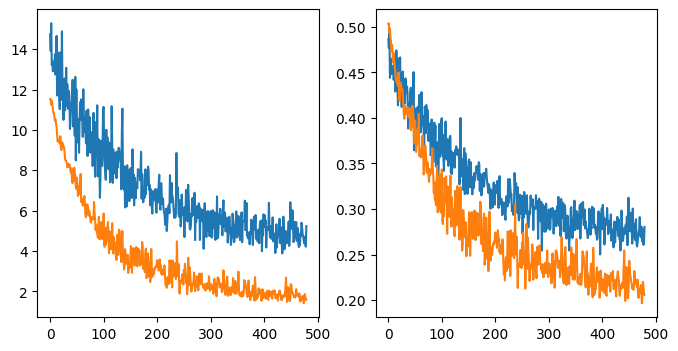

In [19]:
start_num = 20

fig, axes = plt.subplots(1,2, figsize = (8, 4))
axes[0].plot(range(len(estimator_history["train_loss"])-start_num), estimator_history["train_loss"][start_num:])
axes[0].plot(range(len(estimator_history["validation_loss"])-start_num), list(map(lambda x: x.detach().cpu().numpy(), estimator_history["validation_loss"]))[start_num:])

axes[1].plot(range(len(estimator_history["train_abs"])-start_num), estimator_history["train_abs"][start_num:])
axes[1].plot(range(len(estimator_history["validation_abs"])-start_num), estimator_history["validation_abs"][start_num:])

In [ ]:
estimator.predict(torch.Tensor([0,0,7]))

/home/matthias/Documents/EmbeddedAI/deep-microcompression/tests/lenet5_model/../../development/models/estimator.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32, device=self.device)


102.18913269042969

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



sensitivity = lenet5_model.get_layers_prune_channel_sensity_(
    input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun}, device=DEVICE,
    train=False,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

  0%|          | 0/313 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x795d237fd120>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
  0%|          | 0/313 [00:00<?, ?it/s]

6 [(0.0, 99.22), (0.16666666666666666, 97.47), (0.3333333333333333, 71.31), (0.5, 40.65), (0.6666666666666666, 28.36), (0.8333333333333334, 13.94)]
16 [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96), (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97), (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)]
84 [(0.0, 99.05), (0.011904761904761904, 99.08), (0.023809523809523808, 99.04), (0.03571428571428571, 99.2), (0.047619047619047616, 98.98), (0.05952380952380952, 99.19), (0.07142857142857142, 99.16), (0.08333333333333333, 99.09), (0.09523809523809523, 99.09), (0.10714285714285714, 99.11), (0.11904761904761904, 99.18), (0.13095238095238096, 99.07), (0.14285714285714285, 99.1), (0.15476190476190477, 99.08), (0.16666666666666666, 99.03), (0.17857142857142858, 99.28), (0.19047619047619047, 99.25), (0.20238095238095238, 99.17), (0.21428571428571427, 99.14), (0.2261904761904762, 99.07), (0.23

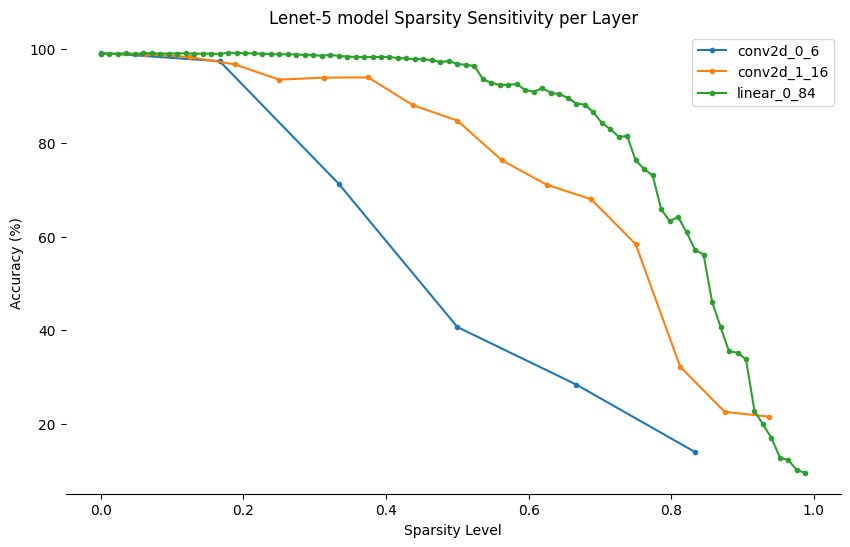

In [ ]:
plt.figure(figsize=(10, 6))
for layer, values in sensitivity['acc'].items():
    print(len(values), values)
    sparsity, acc = zip(*values)
    plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
plt.legend()
plt.grid(False)

list(plt.gca().spines.values())[0].set_visible(False)
list(plt.gca().spines.values())[1].set_visible(False)
list(plt.gca().spines.values())[3].set_visible(False)

plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
plt.show()


4

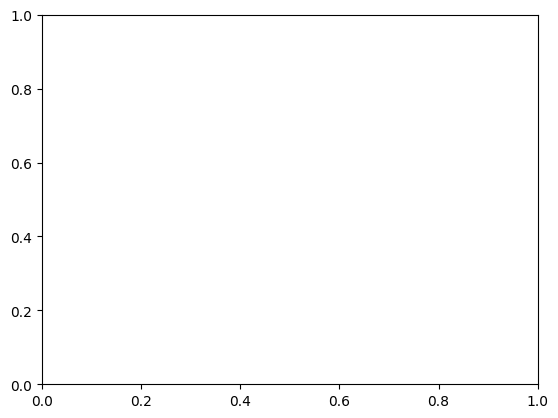

In [ ]:
len(plt.gca().spines.values())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

# Your dataset
acc_data = {
    'conv2d_0': [(0.0, 99.22), (0.1667, 97.47), (0.3333, 71.31), (0.5, 40.65), (0.6667, 28.36), (0.8333, 13.94)],
    'conv2d_1': [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96),
                 (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97),
                 (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)],
    'linear_0': [
        (0.0, 99.05), (0.1667, 99.03), (0.3333, 98.61), (0.5, 96.88), (0.6667, 88.4),
        (0.75, 76.29), (0.8333, 57.14), (0.9167, 22.73), (1.0, 9.52)
    ]
}

# Build dataset as combinations of sparsities
X, y = [], []
for s0, _ in acc_data['conv2d_0']:
    for s1, _ in acc_data['conv2d_1']:
        for s2, acc in acc_data['linear_0']:
            # Features = sparsity levels
            X.append([s0, s1, s2])
            # Approx target = min accuracy among layers (proxy)
            y.append(acc)  

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Example prediction
test_sparsity = torch.tensor([[0.5, 0.25, 0.33]])  # (conv2d_0, conv2d_1, linear_0)
pred_acc = model(test_sparsity).item()
print(f"Predicted Accuracy: {pred_acc:.2f}%")


Epoch 100, Loss: 5958.7373
Epoch 200, Loss: 4314.2148
Epoch 300, Loss: 2123.2832
Epoch 400, Loss: 1662.4471
Epoch 500, Loss: 1510.1141
Predicted Accuracy: 58.12%


In [ ]:
X, y

(tensor([[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.3333],
         ...,
         [0.8333, 0.9375, 0.8333],
         [0.8333, 0.9375, 0.9167],
         [0.8333, 0.9375, 1.0000]]),
 tensor([[99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6

## Original Model


In [ ]:
lenet5_mcu_model = copy.deepcopy(lenet5_model)

evaluate_result = lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 239.41it/s]


The original model accuracy is 9915.00% with size 148240 bytes.
tensor([[-29.0016, -22.3953, -21.4715,  30.5191, -33.2081,   0.8119, -33.4459,
         -16.0511,  -6.0006,  -9.6175]], device='cuda:0')


(99.15, 148240)

In [ ]:
fused_lenet5_mcu_model = lenet5_mcu_model.fuse().to(DEVICE)

evaluate_result = fused_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = fused_lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# fused_lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
fused_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# print(fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone()))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 231.04it/s]


The original model accuracy is 9911.00% with size 148088 bytes.
tensor([[-20.5041, -15.5337,  -1.6605,  -2.1882, -20.7473, -12.2588, -37.9503,
          14.2805, -11.3950,  -7.5340]], device='cuda:0')


(99.11, 148088)

In [ ]:
lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), 

(tensor([[-10.9922, -21.7113, -15.5854,   4.6235, -25.0249,   9.8817,  -9.2897,
          -15.5343,   0.8853,  -8.7347]], device='cuda:0'),)

In [ ]:
fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), \
fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# compression_dict = lenet5_mcu_model.get_all_compression_hyperparameter()
# print(len(compression_dict))
# print((compression_dict)[0])
# lenet5_mcu_model.decode_compression_dict_hyperparameter(compression_dict[0])

In [ ]:
# sp = .9

s = QuantizationScheme.DYNAMIC
g = QuantizationGranularity.PER_TENSOR
b = 4
compression_config = {
    # "prune_channel" :{
    #     "sparsity" : sp,
    #     "metric" : "l2"
    # },
    "quantize" : {
        "scheme" : s,
        "granularity": g,
        "bitwidth" : b
    }
}

# compressed_lenet5_mcu_model = lenet5_mcu_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
compressed_lenet5_mcu_model = lenet5_mcu_model.fuse().init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
before_acc = compressed_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)["acc"]
# compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir)
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir)

size = compressed_lenet5_mcu_model.get_size_in_bits()//8
print(f"Before training, sparsity = {sp}, scheme = {s.name}, granularity = {g.name}, bitwidth = {b} acc = {before_acc:.4f} size = {size/original_size*100:9.4f} {100 - size/original_size*100:9.4f}")

print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir))
print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir))


100%|██████████| 313/313 [00:01<00:00, 171.57it/s]


NameError: name 'sp' is not defined